In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Tuple, Dict, Union, Any, Optional
from tqdm import tqdm
import json
try:
    os.chdir(os.path.join(os.getcwd(), '../../Language-Technology-Project'))
    print(os.getcwd())
except:
    print("ALready in current dir")

c:\Users\mo\Documents\Organisations\RUG\Language-Technology-Project


In [2]:
df = pd.read_csv("datasets/training_merged.csv")
df = df.drop(df.columns[0], axis=1)
df = df.dropna()

df_labels = df.loc[:, df.columns != "Merged"]
df_labels = df_labels.astype(int)
df_labels = df_labels.values.tolist()
df_labels = torch.tensor(df_labels)
df_labels = df_labels.to(torch.float32)

df_inputs = df["Merged"].to_list()
df.head(3)

,Merged,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,we should ban human cloning as it will only ca...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fast food should be banned because it is reall...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sentence_transformers import SentenceTransformer

class HumanValuesDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, device):
        self.inputs = inputs
        self.labels = labels
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)
        self.__preprocess()
        
    def __preprocess(self):
        self.inputs = self.model.encode(self.inputs, show_progress_bar=True)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

In [4]:
data_loader = torch.utils.data.DataLoader(
    HumanValuesDataset(df_inputs, df_labels, torch.device('cuda:0')),
    batch_size=1024,
    shuffle=True,
    num_workers=0,
)

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

In [5]:
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(df.columns[0], axis=1)
    df = df.dropna()

    df_labels = df.loc[:, df.columns != "Merged"]
    df_labels = df_labels.astype(int)
    df_labels = df_labels.values.tolist()
    df_labels = torch.tensor(df_labels)
    df_labels = df_labels.to(torch.float32)

    df_inputs = df["Merged"].to_list()

    return df_inputs, df_labels

def create_dataloader(path, device, batch_size=1024, shuffle=True, num_workers=0, *args, **kwargs):
    df_inputs, df_labels = load_data(path)

    return torch.utils.data.DataLoader(
        HumanValuesDataset(df_inputs, df_labels, device),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        *args,
        **kwargs
    )

In [6]:
class HVClassifier(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        self.fc1 = torch.nn.Linear(768, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(512, 128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.fc3 = torch.nn.Linear(128, 64)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.dropout3 = torch.nn.Dropout(0.2)
        self.fc4 = torch.nn.Linear(64, 32)
        self.bn4 = torch.nn.BatchNorm1d(32)
        self.dropout4 = torch.nn.Dropout(0.2)
        self.fc5 = torch.nn.Linear(32, 20)
        self.bn5 = torch.nn.BatchNorm1d(20)
        self.dropout5 = torch.nn.Dropout(0.2)
        self.fc6 = torch.nn.Linear(20, 20)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is already encoded, use relu activation
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))
        x = self.bn5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        x = self.sigmoid(x)
        return x
    
    def predict(self, x: List[str], return_type="pt") -> np.ndarray:
        x = self.model.encode(x, convert_to_tensor=True, device=next(self.parameters()).device)
        x = self.forward(x)
        x = x.cpu().detach()
        if return_type == "pt":
            return x
        elif return_type == "np":
            return x.numpy()

In [7]:
device = torch.device('cuda:0')
model = HVClassifier().to(device)

In [8]:
train_loader = create_dataloader("datasets/training_merged.csv", device)
val_loader = create_dataloader("datasets/validation_merged.csv", device)

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

  0%|          | 0/1200 [00:00<?, ?it/s]

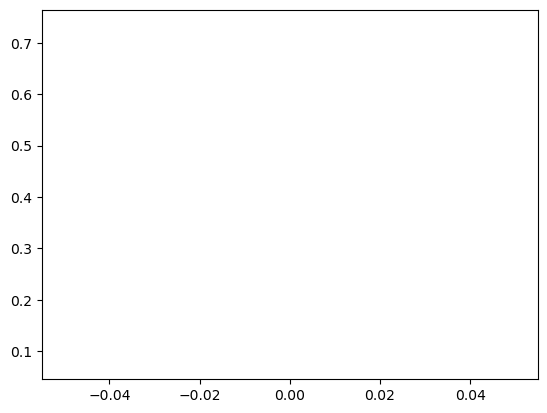

Epoch 1/1200 - loss: 0.7319643298784891, f1: 0.0779316907590013


  1%|          | 10/1200 [00:05<10:48,  1.84it/s]

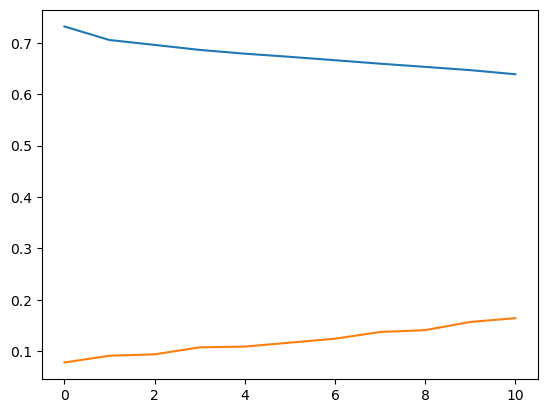

Epoch 11/1200 - loss: 0.6389795045057932, f1: 0.16423170314341662


  2%|▏         | 20/1200 [00:10<08:41,  2.26it/s]

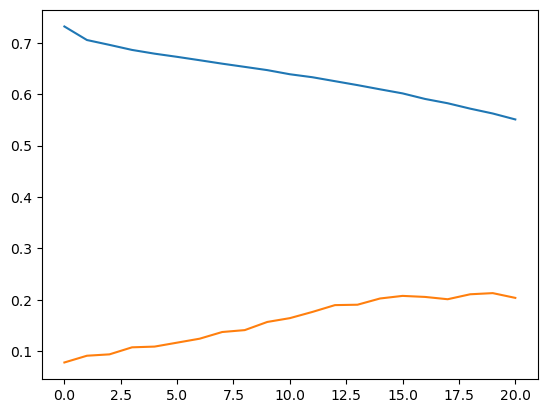

  2%|▏         | 23/1200 [00:10<04:54,  3.99it/s]

Epoch 21/1200 - loss: 0.5510218739509583, f1: 0.20366636217822168


  2%|▏         | 29/1200 [00:11<02:17,  8.52it/s]

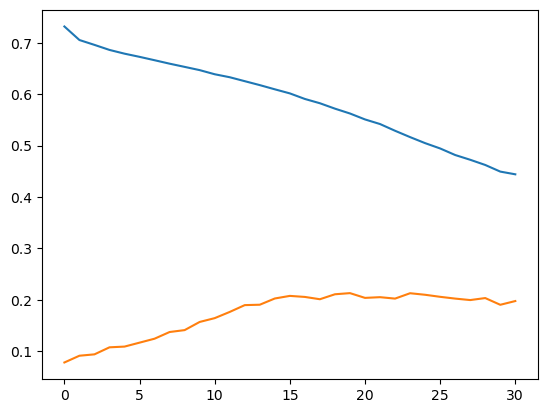

  3%|▎         | 33/1200 [00:11<01:51, 10.49it/s]

Epoch 31/1200 - loss: 0.44419849415620166, f1: 0.19751168594456645


  3%|▎         | 39/1200 [00:11<01:30, 12.87it/s]

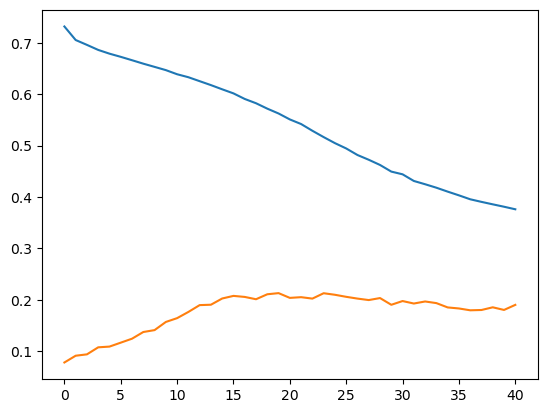

  4%|▎         | 43/1200 [00:12<01:31, 12.64it/s]

Epoch 41/1200 - loss: 0.37613371511300403, f1: 0.19006894858901885


  4%|▍         | 49/1200 [00:12<01:42, 11.23it/s]

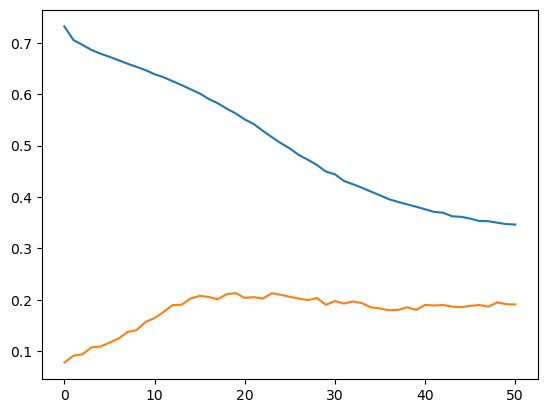

  4%|▍         | 53/1200 [00:13<01:34, 12.19it/s]

Epoch 51/1200 - loss: 0.34635353088378906, f1: 0.19098108859846755


  5%|▍         | 59/1200 [00:13<01:24, 13.51it/s]

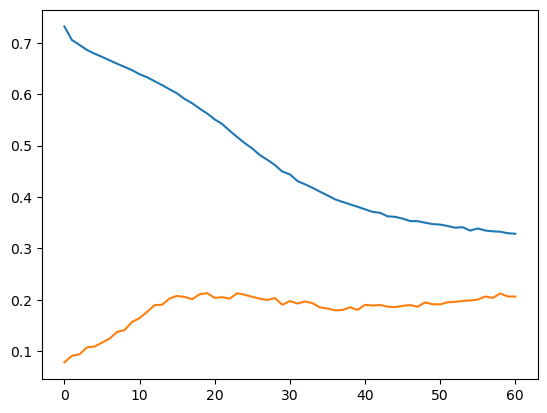

  5%|▌         | 63/1200 [00:13<01:29, 12.66it/s]

Epoch 61/1200 - loss: 0.3284572760264079, f1: 0.20616559855016448


  6%|▌         | 69/1200 [00:14<02:15,  8.33it/s]

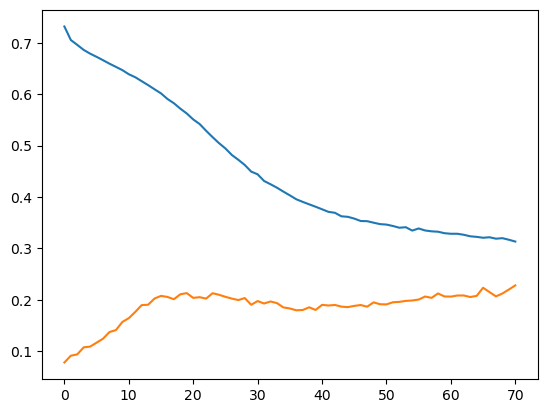

Epoch 71/1200 - loss: 0.3133072257041931, f1: 0.22796817712688083


  7%|▋         | 79/1200 [00:16<02:13,  8.40it/s]

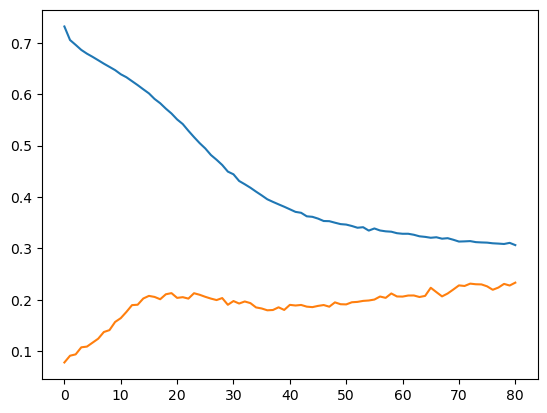

Epoch 81/1200 - loss: 0.30639318625132245, f1: 0.2333281058247727


  7%|▋         | 89/1200 [00:19<04:11,  4.42it/s]

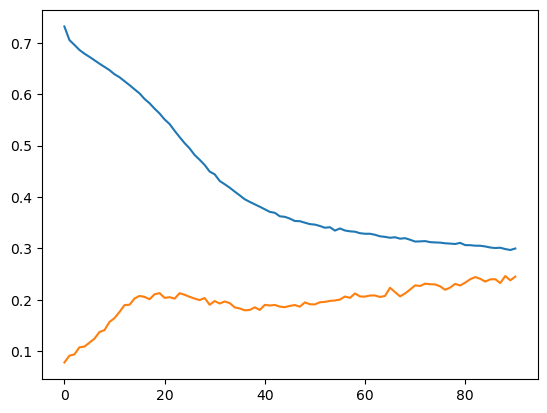

  8%|▊         | 91/1200 [00:19<03:23,  5.45it/s]

Epoch 91/1200 - loss: 0.2997722228368123, f1: 0.24506760246518045


  8%|▊         | 100/1200 [00:21<03:25,  5.34it/s]

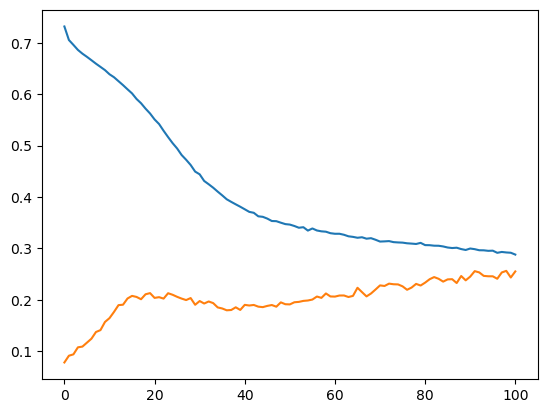

  8%|▊         | 101/1200 [00:21<03:16,  5.59it/s]

Epoch 101/1200 - loss: 0.28795411189397174, f1: 0.2551670757302119


  9%|▉         | 109/1200 [00:23<03:48,  4.78it/s]

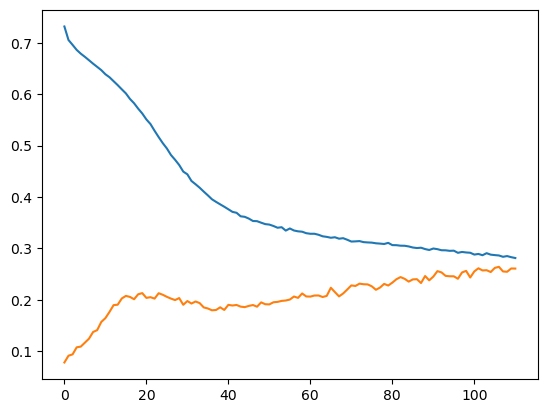

  9%|▉         | 111/1200 [00:23<03:08,  5.77it/s]

Epoch 111/1200 - loss: 0.2812589506308238, f1: 0.2607160560049447


 10%|▉         | 119/1200 [00:25<02:59,  6.01it/s]

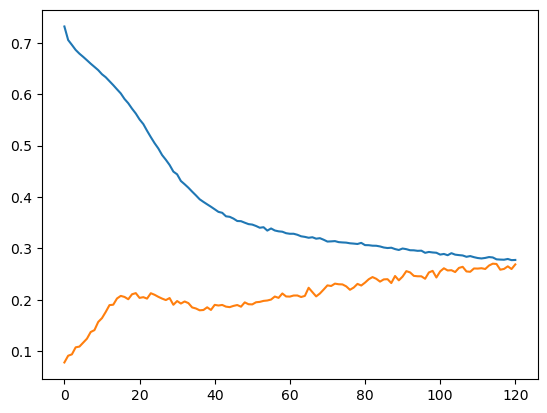

 10%|█         | 123/1200 [00:25<02:15,  7.97it/s]

Epoch 121/1200 - loss: 0.2775129626194636, f1: 0.26881799863956957


 11%|█         | 129/1200 [00:27<04:31,  3.95it/s]

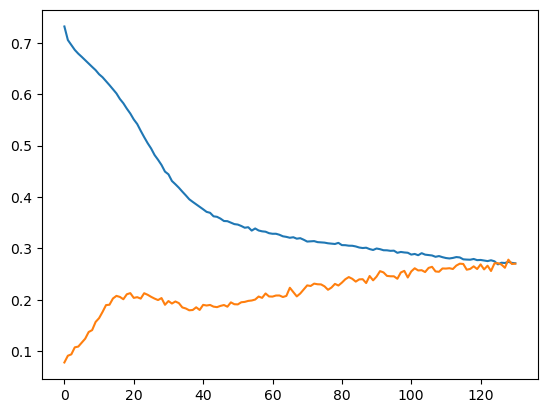

 11%|█         | 132/1200 [00:27<03:12,  5.56it/s]

Epoch 131/1200 - loss: 0.27101672689119977, f1: 0.27022579191677343


 12%|█▏        | 139/1200 [00:28<01:37, 10.90it/s]

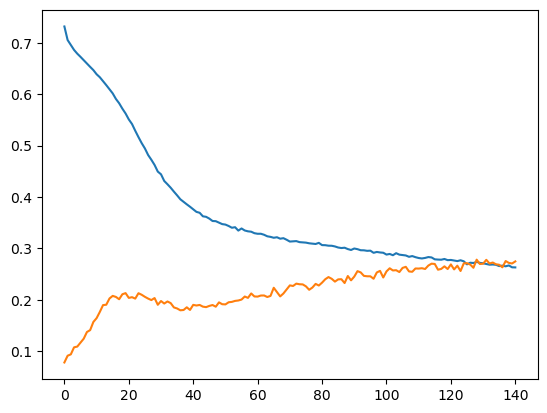

 12%|█▏        | 141/1200 [00:28<01:37, 10.86it/s]

Epoch 141/1200 - loss: 0.26297679046789807, f1: 0.27466237497912405


 12%|█▎        | 150/1200 [00:31<05:01,  3.48it/s]

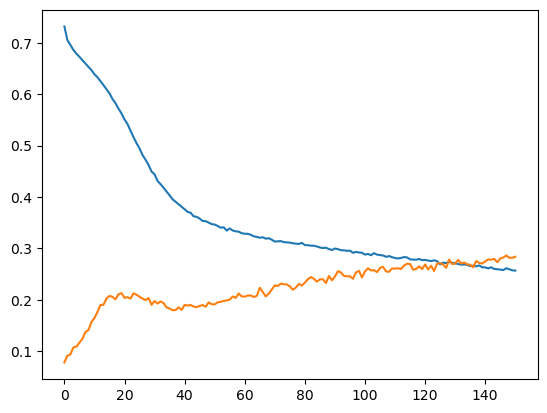

 13%|█▎        | 151/1200 [00:31<04:26,  3.94it/s]

Epoch 151/1200 - loss: 0.2567280555764834, f1: 0.28379984657851437


 13%|█▎        | 159/1200 [00:33<03:27,  5.02it/s]

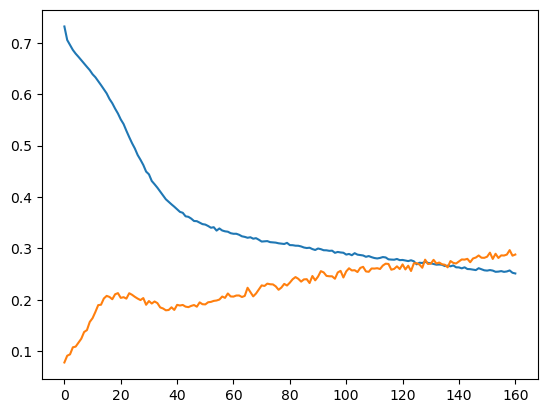

 14%|█▎        | 163/1200 [00:33<02:23,  7.21it/s]

Epoch 161/1200 - loss: 0.2512113998333613, f1: 0.28806341465935736


 14%|█▍        | 169/1200 [00:34<01:32, 11.19it/s]

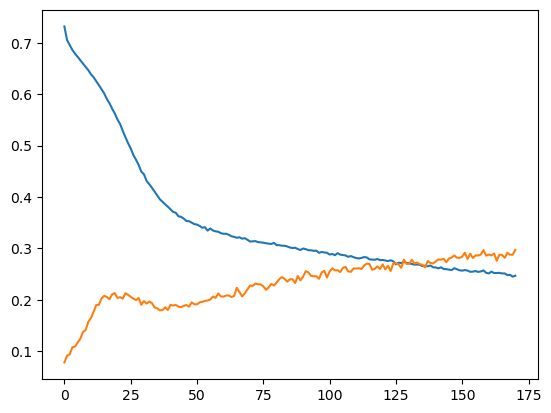

Epoch 171/1200 - loss: 0.24683508773644766, f1: 0.2970482392715337


 15%|█▍        | 179/1200 [00:35<03:02,  5.60it/s]

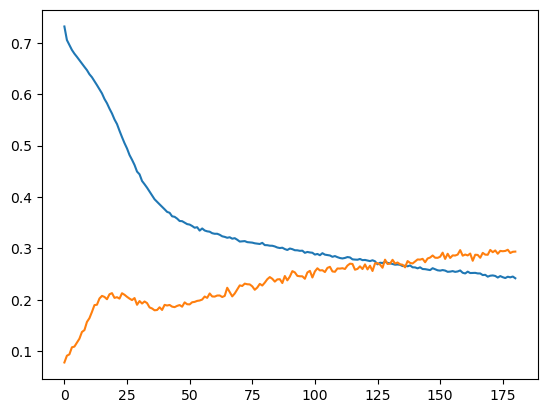

 15%|█▌        | 183/1200 [00:36<02:15,  7.52it/s]

Epoch 181/1200 - loss: 0.241871178150177, f1: 0.29377677746350983


 16%|█▌        | 190/1200 [00:37<03:15,  5.16it/s]

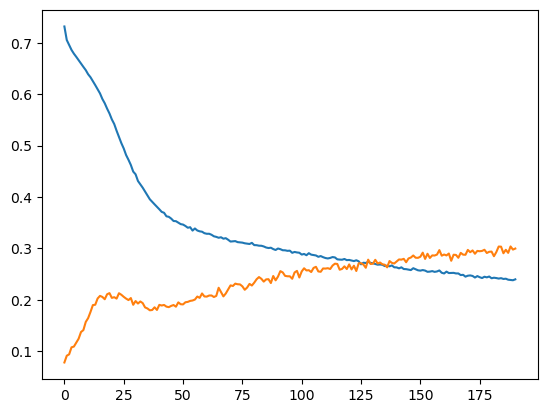

 16%|█▌        | 191/1200 [00:37<03:04,  5.48it/s]

Epoch 191/1200 - loss: 0.23974622786045074, f1: 0.29968999985240585


 17%|█▋        | 200/1200 [00:40<03:08,  5.31it/s]

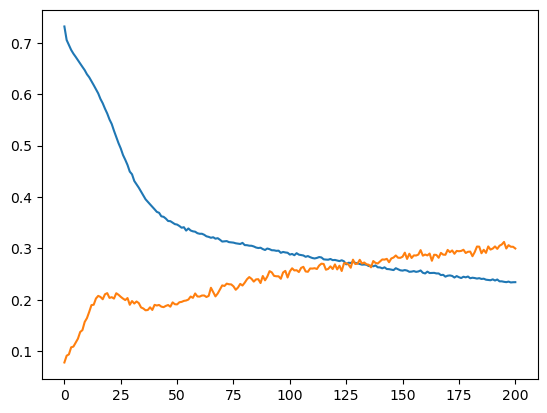

 17%|█▋        | 202/1200 [00:40<02:41,  6.17it/s]

Epoch 201/1200 - loss: 0.23425794144471487, f1: 0.29984272852110067


 18%|█▊        | 210/1200 [00:41<01:49,  9.00it/s]

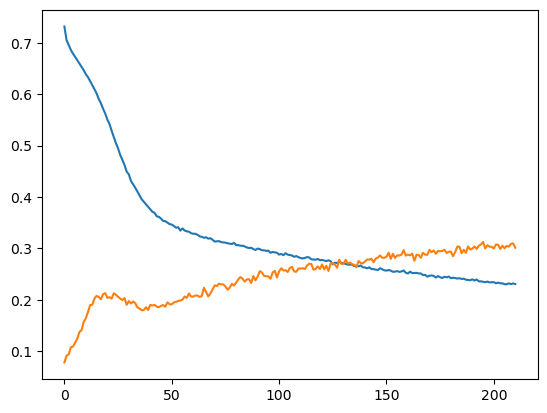

 18%|█▊        | 212/1200 [00:41<01:49,  9.06it/s]

Epoch 211/1200 - loss: 0.23050455749034882, f1: 0.30127431459358006


 18%|█▊        | 220/1200 [00:42<01:53,  8.65it/s]

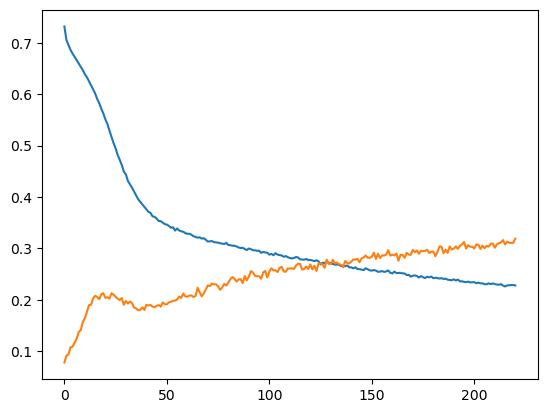

Epoch 221/1200 - loss: 0.2278758188088735, f1: 0.3189149468342015


 19%|█▉        | 230/1200 [00:43<01:34, 10.25it/s]

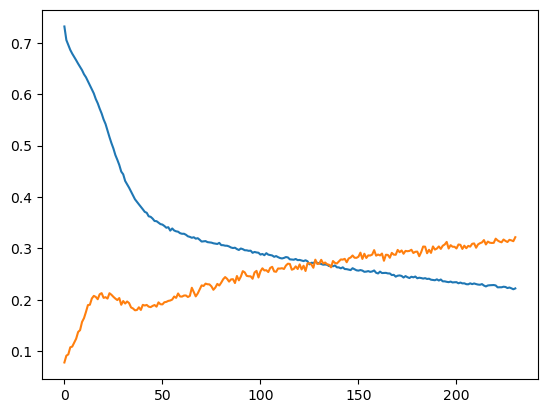

Epoch 231/1200 - loss: 0.22211533039808273, f1: 0.3218020338981946


 20%|██        | 240/1200 [00:45<01:50,  8.73it/s]

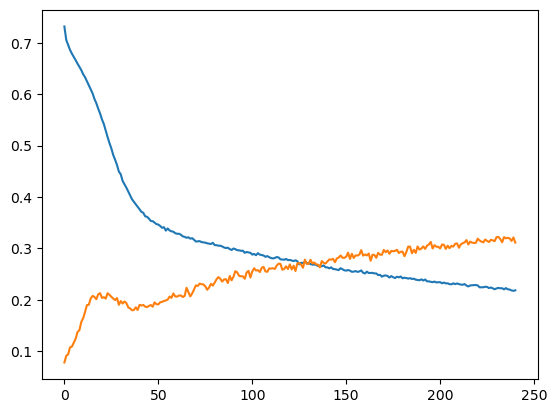

 20%|██        | 242/1200 [00:45<01:45,  9.11it/s]

Epoch 241/1200 - loss: 0.2183977539340655, f1: 0.3112960330183606


 21%|██        | 250/1200 [00:47<02:04,  7.62it/s]

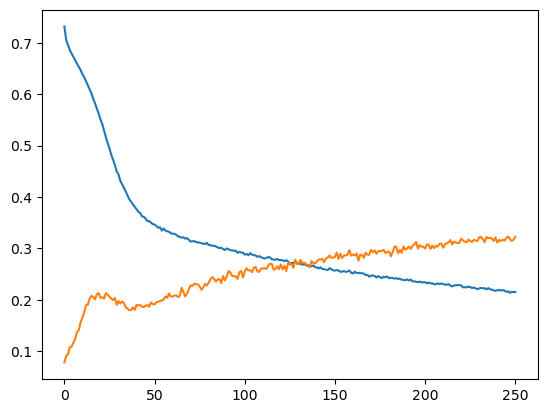

 21%|██        | 252/1200 [00:47<01:56,  8.17it/s]

Epoch 251/1200 - loss: 0.21503358334302902, f1: 0.32259425656276636


 22%|██▏       | 260/1200 [00:47<01:15, 12.47it/s]

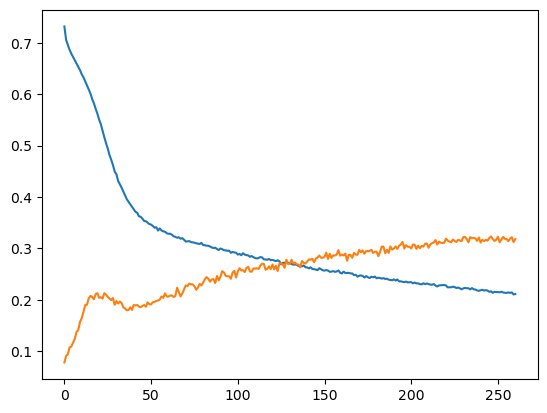

Epoch 261/1200 - loss: 0.21119341999292374, f1: 0.3181155601414274


 22%|██▎       | 270/1200 [00:49<01:50,  8.45it/s]

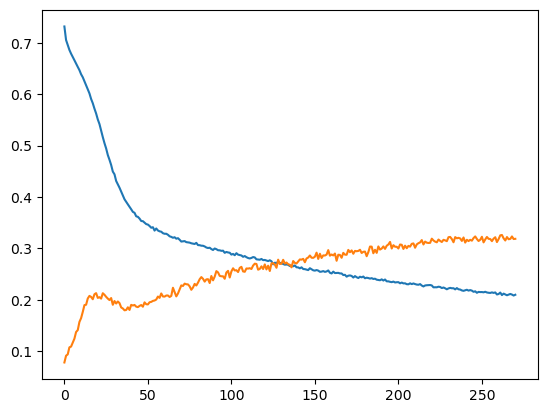

Epoch 271/1200 - loss: 0.20973928521076837, f1: 0.3185996599041227


 23%|██▎       | 280/1200 [00:51<01:55,  7.98it/s]

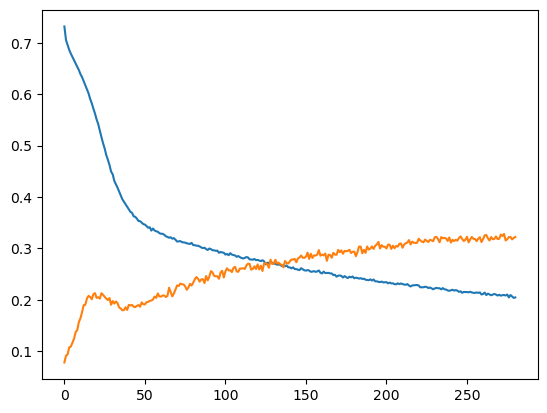

 24%|██▎       | 282/1200 [00:51<01:52,  8.18it/s]

Epoch 281/1200 - loss: 0.20457826058069864, f1: 0.3221817294955076


 24%|██▍       | 290/1200 [00:52<01:11, 12.77it/s]

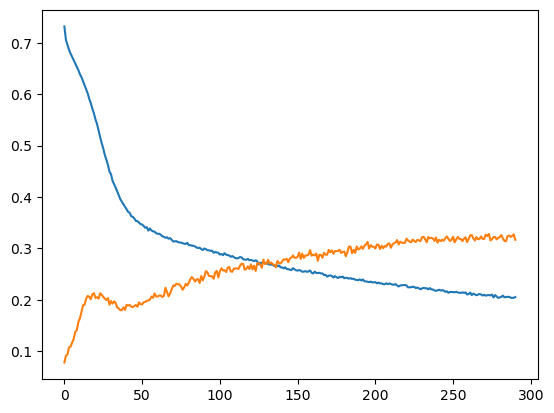

 24%|██▍       | 292/1200 [00:52<01:19, 11.36it/s]

Epoch 291/1200 - loss: 0.20527886847654978, f1: 0.31674712339143163


 25%|██▌       | 300/1200 [00:53<01:48,  8.26it/s]

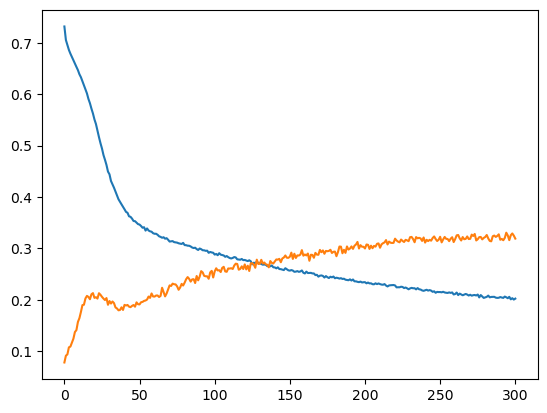

 25%|██▌       | 302/1200 [00:53<01:46,  8.41it/s]

Epoch 301/1200 - loss: 0.2022197445233663, f1: 0.31906027497041517


 26%|██▌       | 310/1200 [00:54<02:19,  6.37it/s]

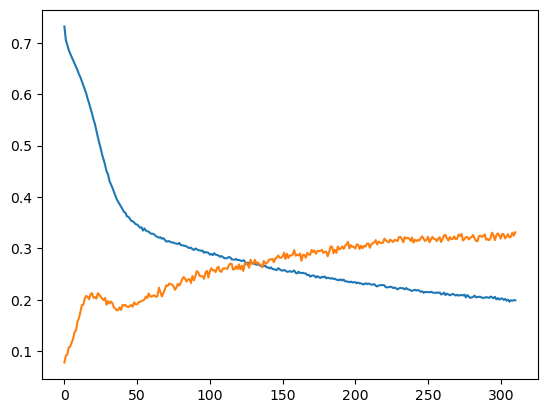

Epoch 311/1200 - loss: 0.19887512177228928, f1: 0.3313261951657396


 27%|██▋       | 320/1200 [00:57<04:03,  3.61it/s]

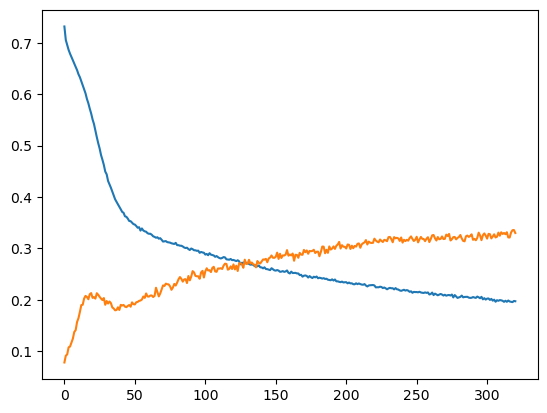

 27%|██▋       | 323/1200 [00:57<02:41,  5.42it/s]

Epoch 321/1200 - loss: 0.1971594567100207, f1: 0.32996839601607303


 27%|██▋       | 329/1200 [00:58<01:40,  8.63it/s]

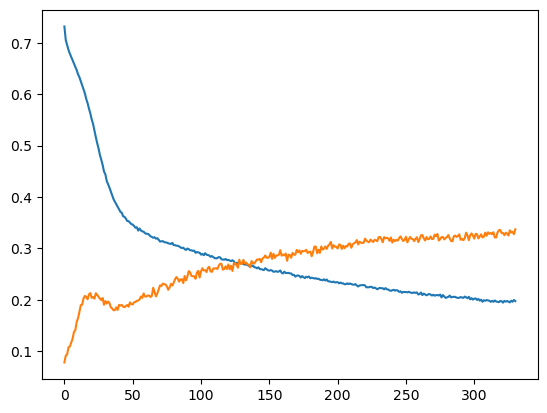

Epoch 331/1200 - loss: 0.19741028298934302, f1: 0.33710147535564405


 28%|██▊       | 339/1200 [00:59<01:26,  9.96it/s]

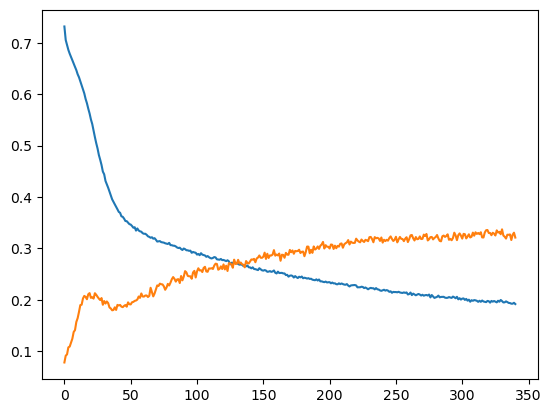

 29%|██▊       | 343/1200 [00:59<01:19, 10.79it/s]

Epoch 341/1200 - loss: 0.1916491612792015, f1: 0.3210807502999906


 29%|██▉       | 349/1200 [01:00<01:05, 13.04it/s]

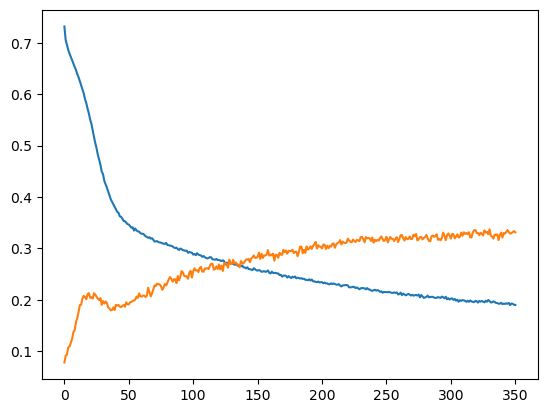

 29%|██▉       | 353/1200 [01:00<01:08, 12.40it/s]

Epoch 351/1200 - loss: 0.1899451563755671, f1: 0.33120921510452006


 30%|██▉       | 359/1200 [01:01<02:00,  6.96it/s]

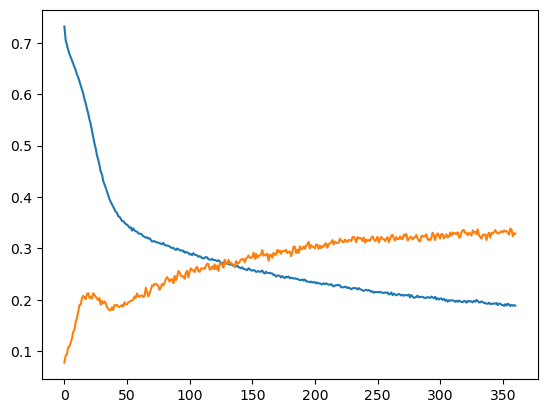

 30%|███       | 363/1200 [01:02<01:35,  8.74it/s]

Epoch 361/1200 - loss: 0.1885922575990359, f1: 0.32890284680231857


 31%|███       | 369/1200 [01:02<01:12, 11.51it/s]

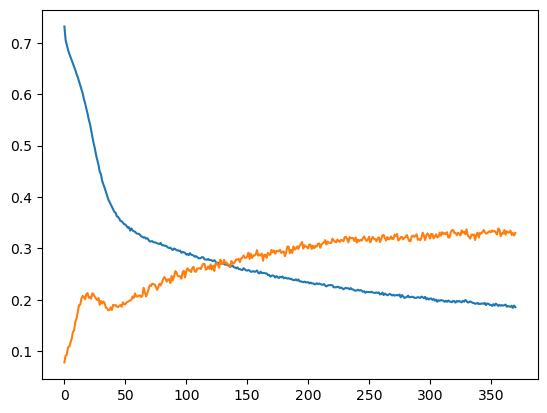

 31%|███       | 371/1200 [01:02<01:17, 10.68it/s]

Epoch 371/1200 - loss: 0.1856784795721372, f1: 0.3302012296988964


 32%|███▏      | 379/1200 [01:03<01:21, 10.08it/s]

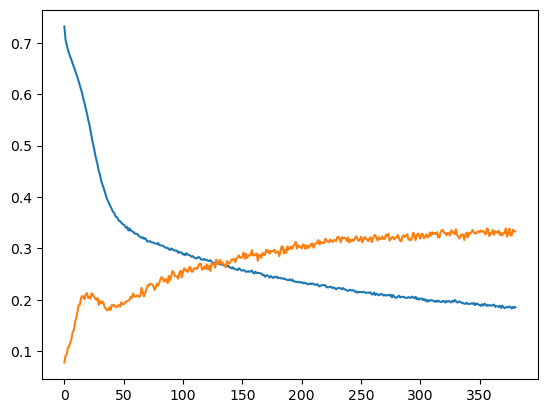

 32%|███▏      | 383/1200 [01:04<01:17, 10.52it/s]

Epoch 381/1200 - loss: 0.18567678332328796, f1: 0.3330694473827003


 32%|███▏      | 389/1200 [01:04<01:00, 13.32it/s]

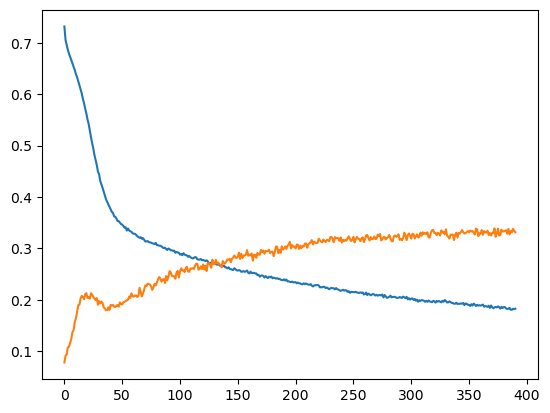

 33%|███▎      | 393/1200 [01:04<01:12, 11.07it/s]

Epoch 391/1200 - loss: 0.182611346244812, f1: 0.33144314941679964


 33%|███▎      | 399/1200 [01:05<01:44,  7.64it/s]

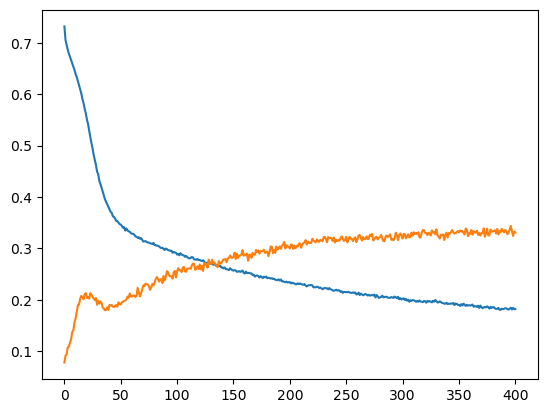

 34%|███▎      | 403/1200 [01:06<01:29,  8.87it/s]

Epoch 401/1200 - loss: 0.18182004491488138, f1: 0.3311424198821685


 34%|███▍      | 409/1200 [01:06<01:08, 11.53it/s]

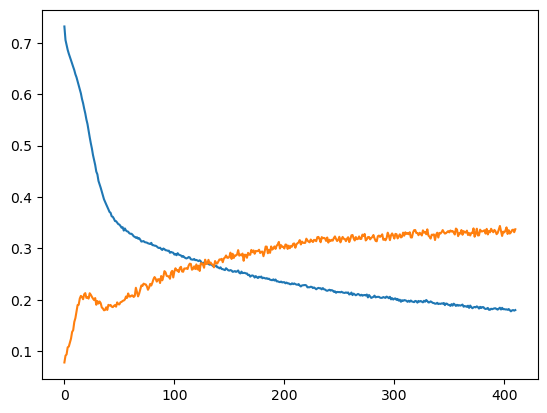

 34%|███▍      | 413/1200 [01:07<01:06, 11.79it/s]

Epoch 411/1200 - loss: 0.1799564783771833, f1: 0.33727878082921725


 35%|███▌      | 420/1200 [01:08<02:15,  5.76it/s]

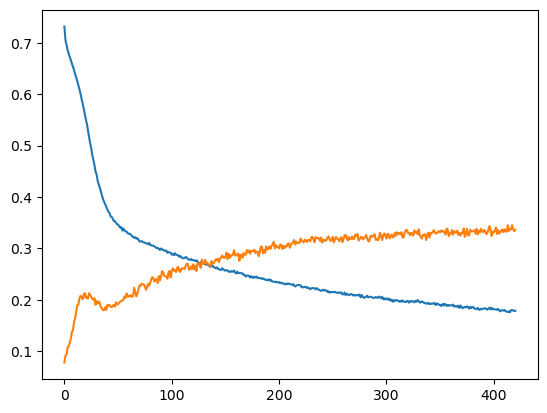

 35%|███▌      | 421/1200 [01:08<02:09,  6.02it/s]

Epoch 421/1200 - loss: 0.178568663696448, f1: 0.33623151153454983


 36%|███▌      | 429/1200 [01:09<01:09, 11.16it/s]

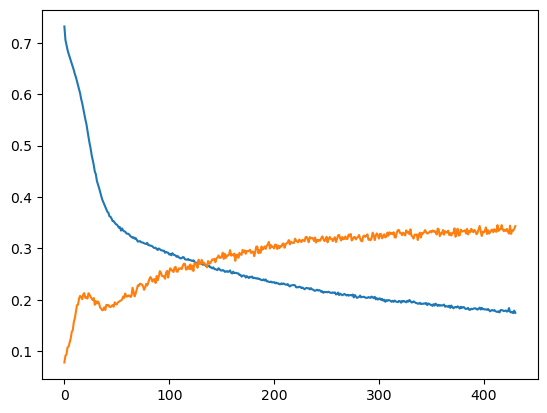

 36%|███▌      | 433/1200 [01:09<01:07, 11.45it/s]

Epoch 431/1200 - loss: 0.17450943340857825, f1: 0.34335021096197105


 37%|███▋      | 439/1200 [01:10<00:57, 13.20it/s]

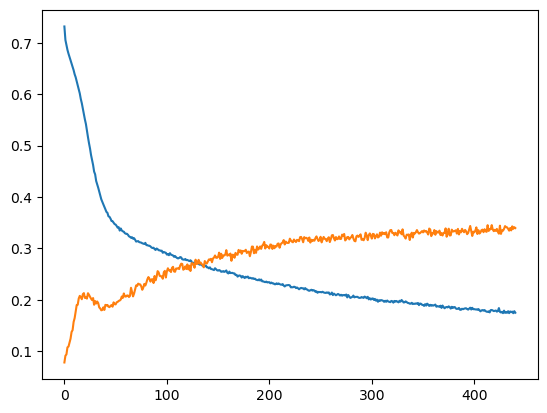

 37%|███▋      | 443/1200 [01:10<00:57, 13.05it/s]

Epoch 441/1200 - loss: 0.17478603621323904, f1: 0.3395716382924069


 37%|███▋      | 449/1200 [01:11<01:03, 11.80it/s]

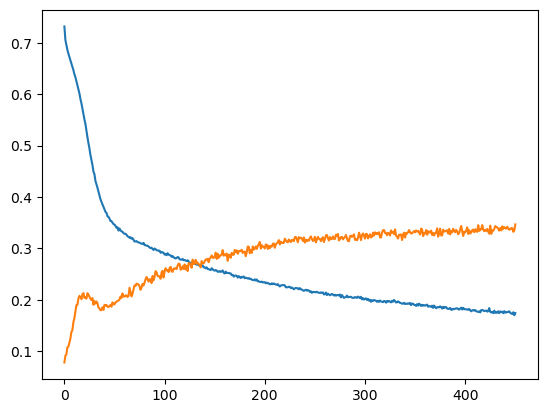

Epoch 451/1200 - loss: 0.17403335372606912, f1: 0.34663696807562183


 38%|███▊      | 459/1200 [01:12<01:07, 11.05it/s]

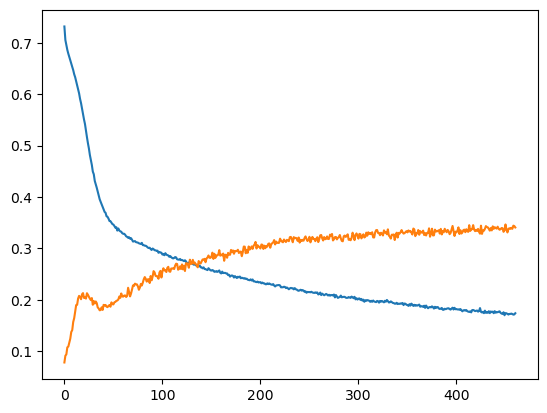

 39%|███▊      | 463/1200 [01:12<01:04, 11.43it/s]

Epoch 461/1200 - loss: 0.17382034411032996, f1: 0.34072376627186357


 39%|███▉      | 469/1200 [01:13<00:53, 13.78it/s]

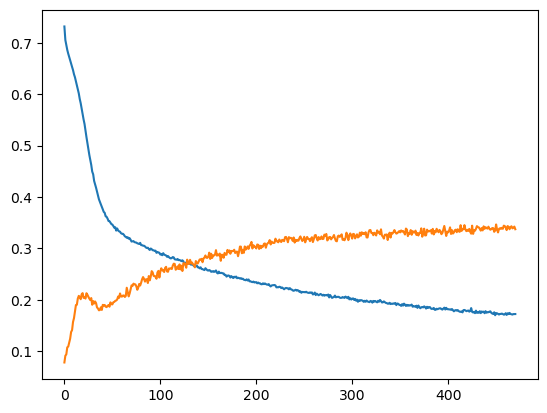

 39%|███▉      | 473/1200 [01:13<01:02, 11.57it/s]

Epoch 471/1200 - loss: 0.17221011718114218, f1: 0.3373129763689077


 40%|███▉      | 479/1200 [01:13<00:54, 13.24it/s]

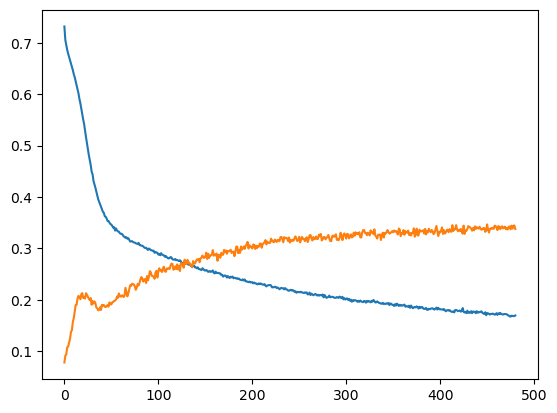

 40%|████      | 483/1200 [01:14<01:04, 11.13it/s]

Epoch 481/1200 - loss: 0.16942392537991205, f1: 0.33775864335640904


 41%|████      | 489/1200 [01:14<00:54, 13.00it/s]

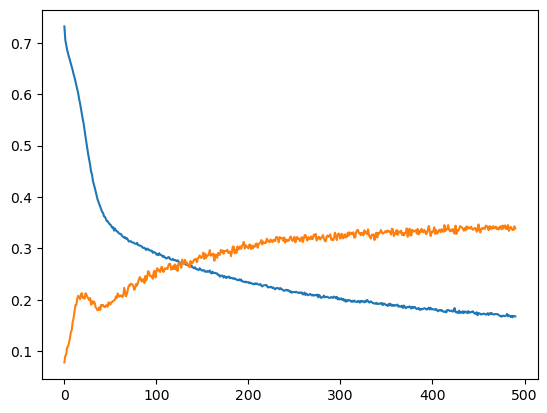

 41%|████      | 493/1200 [01:15<00:57, 12.40it/s]

Epoch 491/1200 - loss: 0.16776146491368613, f1: 0.3387315607550824


 42%|████▏     | 499/1200 [01:15<00:49, 14.20it/s]

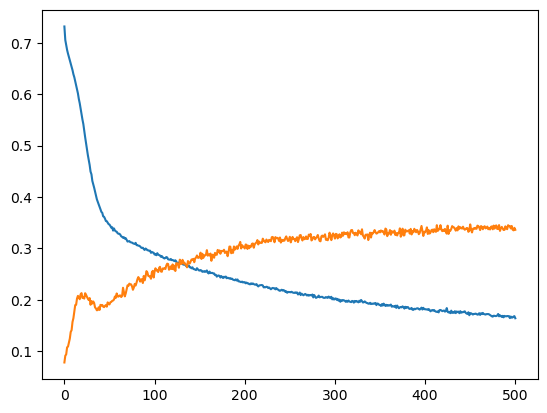

 42%|████▏     | 501/1200 [01:15<00:53, 12.96it/s]

Epoch 501/1200 - loss: 0.1640582432349523, f1: 0.3362291428736904


 42%|████▏     | 509/1200 [01:16<01:08, 10.11it/s]

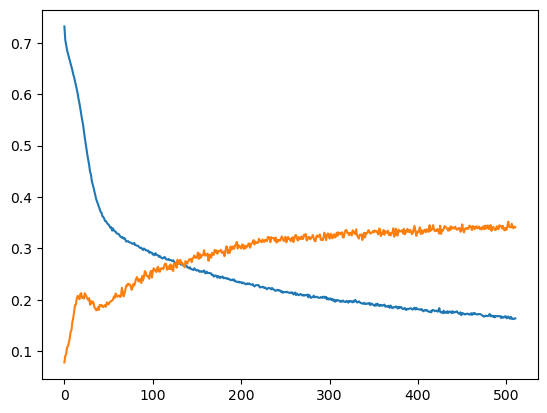

 43%|████▎     | 513/1200 [01:17<01:10,  9.80it/s]

Epoch 511/1200 - loss: 0.16367518156766891, f1: 0.34139285134157227


 43%|████▎     | 519/1200 [01:18<01:28,  7.66it/s]

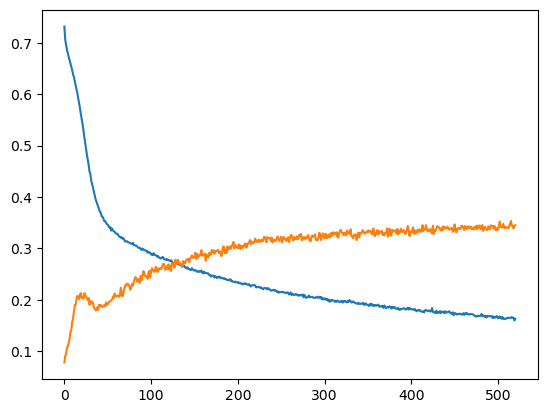

 44%|████▎     | 523/1200 [01:18<01:16,  8.87it/s]

Epoch 521/1200 - loss: 0.16260603070259094, f1: 0.34505838606358463


 44%|████▍     | 529/1200 [01:18<00:57, 11.62it/s]

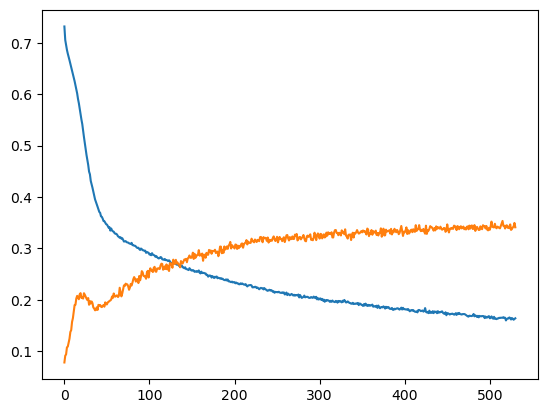

 44%|████▍     | 533/1200 [01:19<00:55, 12.09it/s]

Epoch 531/1200 - loss: 0.16393001129229864, f1: 0.34109897781542087


 45%|████▍     | 539/1200 [01:19<00:47, 13.77it/s]

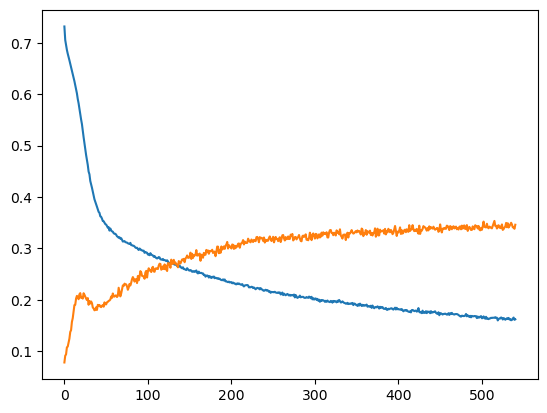

 45%|████▌     | 541/1200 [01:19<00:54, 12.02it/s]

Epoch 541/1200 - loss: 0.1619813193877538, f1: 0.3460284051068604


 46%|████▌     | 549/1200 [01:20<00:52, 12.47it/s]

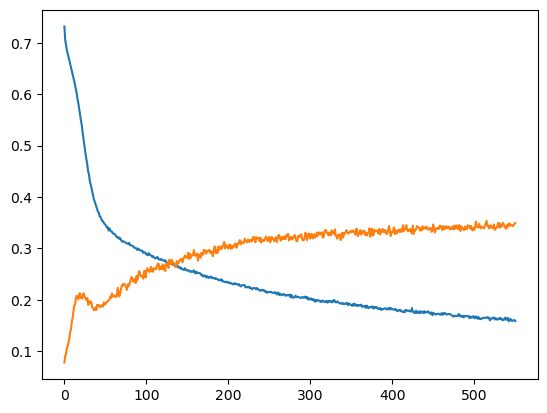

 46%|████▌     | 553/1200 [01:20<00:54, 11.86it/s]

Epoch 551/1200 - loss: 0.15856435894966125, f1: 0.34946707734541904


 47%|████▋     | 559/1200 [01:21<00:48, 13.15it/s]

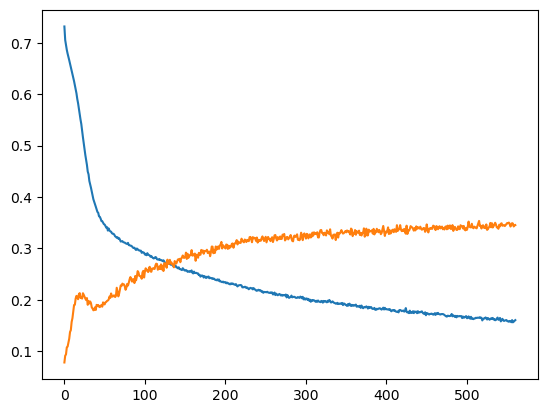

 47%|████▋     | 563/1200 [01:21<00:49, 12.97it/s]

Epoch 561/1200 - loss: 0.16038734714190164, f1: 0.3453637248780922


 47%|████▋     | 569/1200 [01:22<00:48, 13.00it/s]

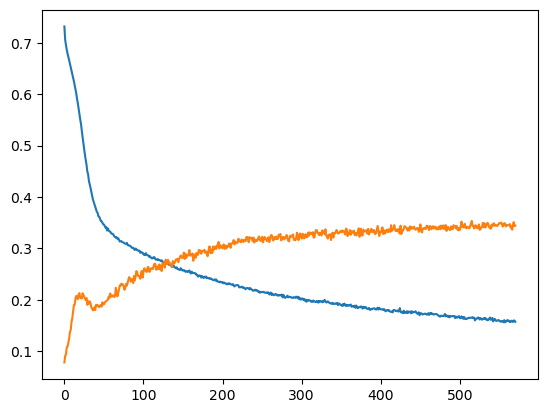

 48%|████▊     | 571/1200 [01:22<00:52, 12.01it/s]

Epoch 571/1200 - loss: 0.15709981818993887, f1: 0.3441399716549555


 48%|████▊     | 579/1200 [01:23<00:51, 12.00it/s]

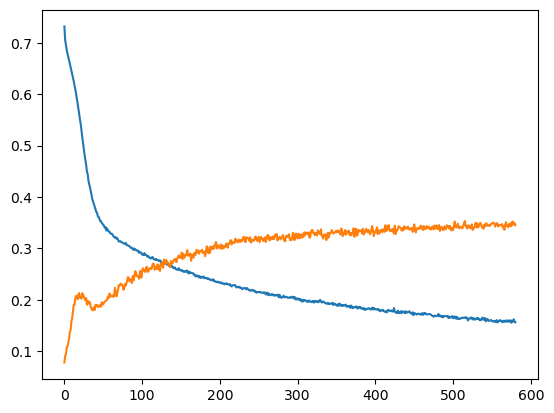

 49%|████▊     | 583/1200 [01:23<00:50, 12.16it/s]

Epoch 581/1200 - loss: 0.15625191976626715, f1: 0.3450242209545082


 49%|████▉     | 589/1200 [01:23<00:47, 12.80it/s]

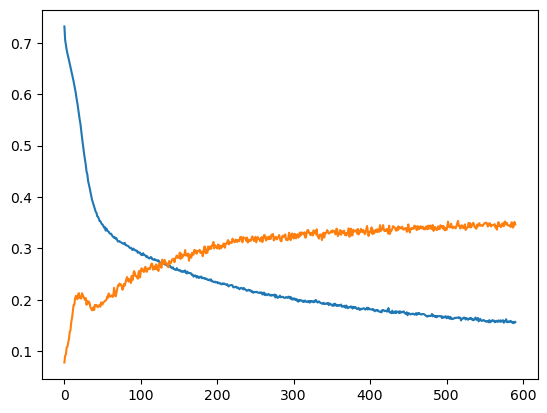

 49%|████▉     | 593/1200 [01:24<00:49, 12.34it/s]

Epoch 591/1200 - loss: 0.15653597811857858, f1: 0.3466697650282265


 50%|████▉     | 599/1200 [01:24<00:42, 14.19it/s]

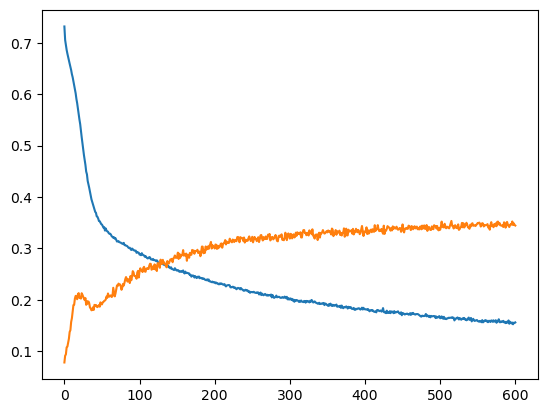

 50%|█████     | 603/1200 [01:24<00:50, 11.84it/s]

Epoch 601/1200 - loss: 0.15585861106713614, f1: 0.3444908139090122


 51%|█████     | 609/1200 [01:25<00:50, 11.66it/s]

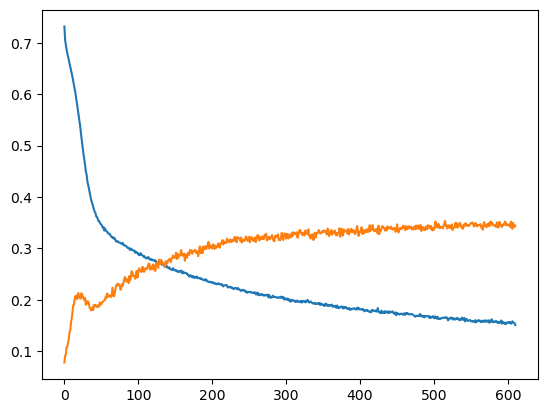

 51%|█████     | 613/1200 [01:25<00:49, 11.74it/s]

Epoch 611/1200 - loss: 0.15074098110198975, f1: 0.34444793662615214


 52%|█████▏    | 619/1200 [01:26<00:43, 13.47it/s]

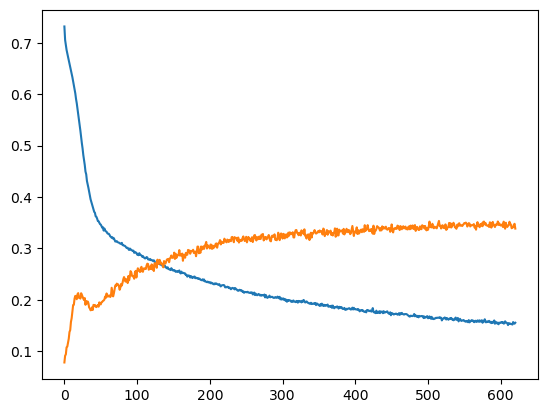

 52%|█████▏    | 623/1200 [01:26<00:45, 12.57it/s]

Epoch 621/1200 - loss: 0.15527786066134772, f1: 0.33856474736758957


 52%|█████▏    | 629/1200 [01:26<00:40, 14.11it/s]

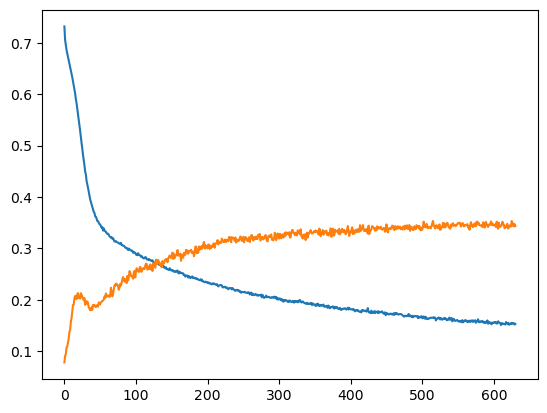

 53%|█████▎    | 633/1200 [01:27<00:42, 13.19it/s]

Epoch 631/1200 - loss: 0.15288357436656952, f1: 0.34336606052987706


 53%|█████▎    | 639/1200 [01:27<00:51, 10.89it/s]

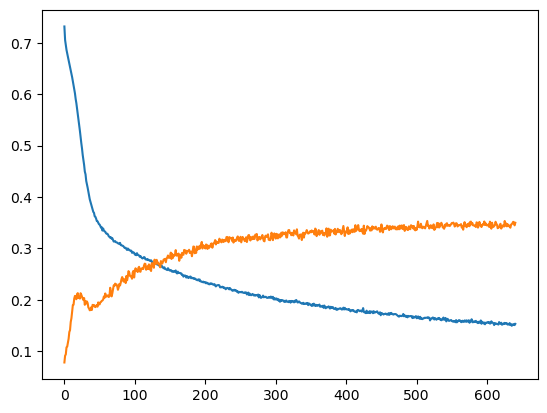

 54%|█████▎    | 643/1200 [01:28<00:47, 11.65it/s]

Epoch 641/1200 - loss: 0.1530353327592214, f1: 0.3498710853640954


 54%|█████▍    | 649/1200 [01:28<00:40, 13.53it/s]

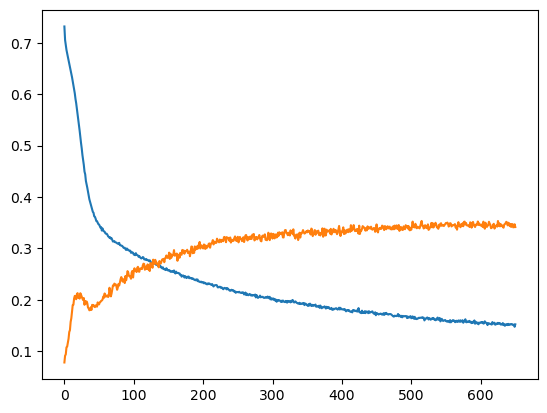

 54%|█████▍    | 653/1200 [01:28<00:43, 12.56it/s]

Epoch 651/1200 - loss: 0.15212265898784003, f1: 0.34154526746409797


 55%|█████▍    | 659/1200 [01:29<00:39, 13.64it/s]

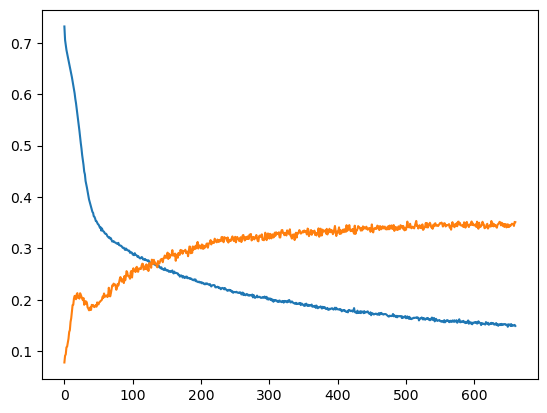

 55%|█████▌    | 661/1200 [01:29<00:43, 12.42it/s]

Epoch 661/1200 - loss: 0.14910037070512772, f1: 0.3511079687002733


 56%|█████▌    | 669/1200 [01:30<00:59,  8.86it/s]

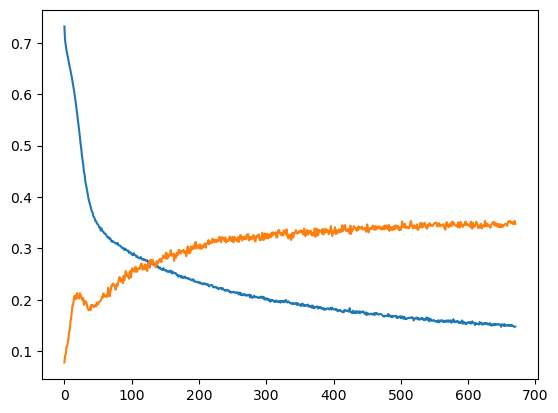

 56%|█████▌    | 671/1200 [01:31<01:36,  5.48it/s]

Epoch 671/1200 - loss: 0.14778181165456772, f1: 0.34768698608040494


 57%|█████▋    | 680/1200 [01:33<01:08,  7.55it/s]

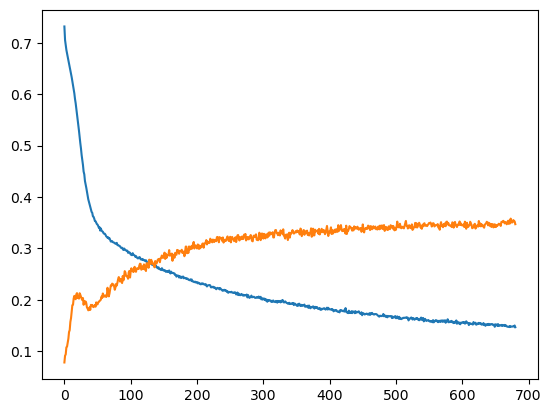

 57%|█████▋    | 682/1200 [01:33<01:04,  8.09it/s]

Epoch 681/1200 - loss: 0.14654619246721268, f1: 0.34712788612395284


 57%|█████▊    | 690/1200 [01:34<01:02,  8.19it/s]

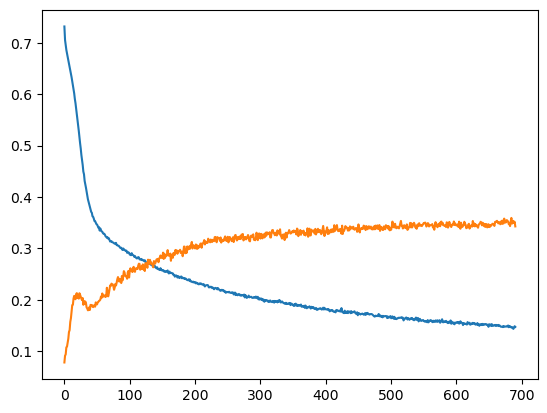

 58%|█████▊    | 694/1200 [01:34<00:50,  9.95it/s]

Epoch 691/1200 - loss: 0.14714958518743515, f1: 0.3427858220325719


 58%|█████▊    | 700/1200 [01:35<00:41, 12.08it/s]

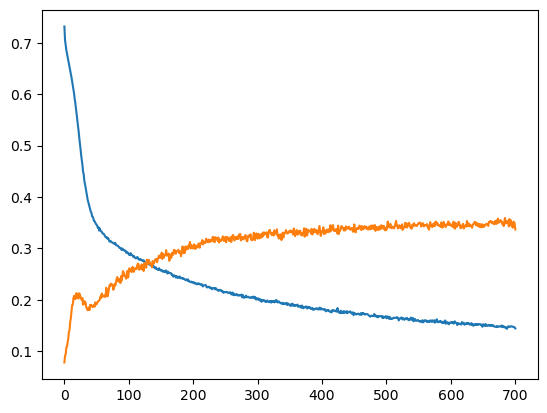

 58%|█████▊    | 702/1200 [01:35<00:51,  9.65it/s]

Epoch 701/1200 - loss: 0.14422023048003516, f1: 0.3367846278917613


 59%|█████▉    | 710/1200 [01:36<00:37, 13.05it/s]

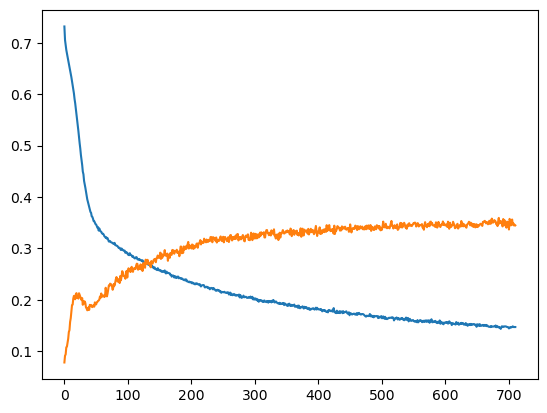

 59%|█████▉    | 712/1200 [01:36<00:43, 11.27it/s]

Epoch 711/1200 - loss: 0.1469556118051211, f1: 0.3448633986921311


 60%|██████    | 720/1200 [01:36<00:35, 13.63it/s]

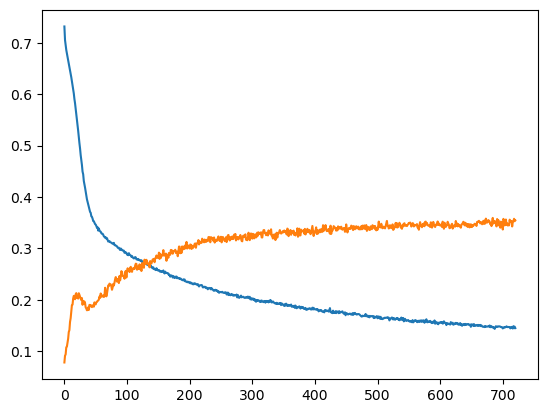

 60%|██████    | 722/1200 [01:37<00:39, 12.06it/s]

Epoch 721/1200 - loss: 0.1448003202676773, f1: 0.3545179460108002


 61%|██████    | 730/1200 [01:37<00:32, 14.35it/s]

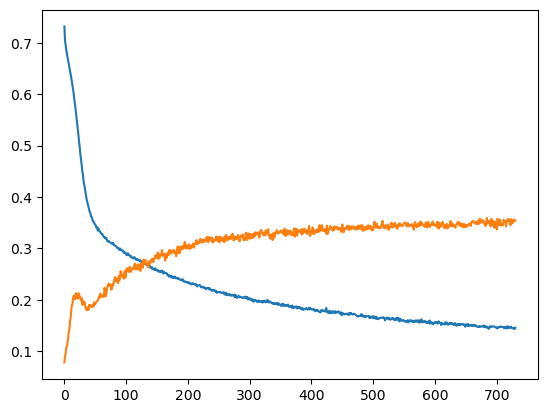

 61%|██████    | 732/1200 [01:37<00:46, 10.03it/s]

Epoch 731/1200 - loss: 0.14567652344703674, f1: 0.3541814494882304


 62%|██████▏   | 740/1200 [01:38<00:50,  9.03it/s]

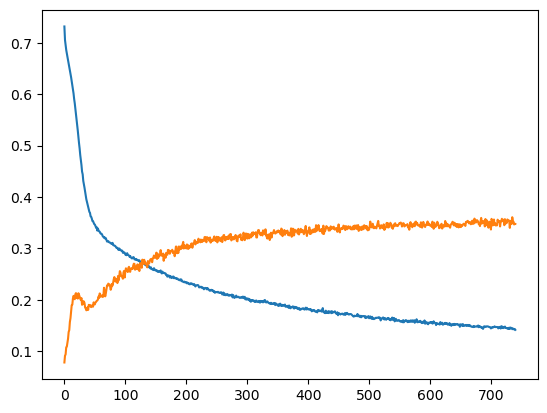

 62%|██████▏   | 742/1200 [01:39<00:49,  9.21it/s]

Epoch 741/1200 - loss: 0.1414943387111028, f1: 0.34762319118751617


 62%|██████▎   | 750/1200 [01:39<00:35, 12.83it/s]

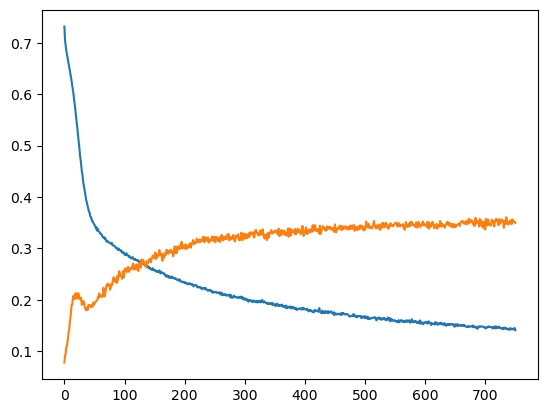

 63%|██████▎   | 752/1200 [01:39<00:37, 11.79it/s]

Epoch 751/1200 - loss: 0.14055329064528146, f1: 0.34952549870002847


 63%|██████▎   | 760/1200 [01:40<00:31, 13.79it/s]

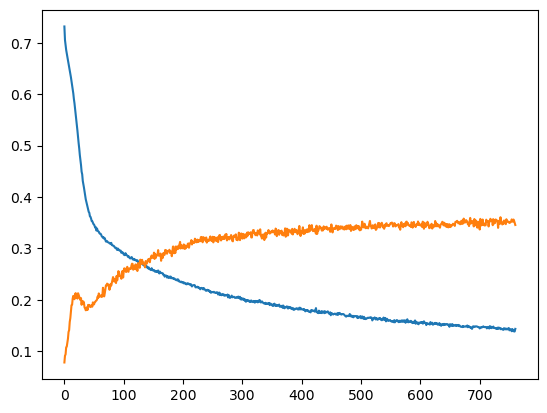

 64%|██████▎   | 762/1200 [01:40<00:38, 11.41it/s]

Epoch 761/1200 - loss: 0.14332222441832224, f1: 0.3456166152053559


 64%|██████▍   | 770/1200 [01:41<00:33, 12.72it/s]

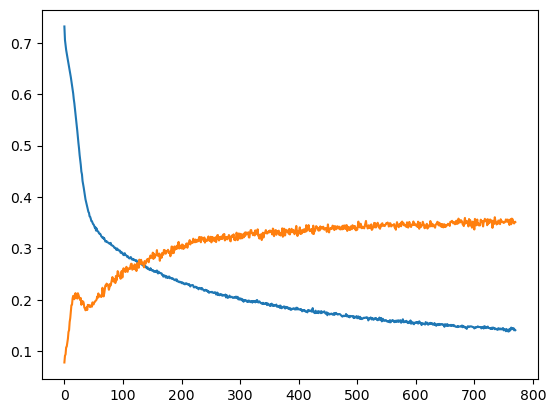

 64%|██████▍   | 772/1200 [01:41<00:37, 11.30it/s]

Epoch 771/1200 - loss: 0.140850360194842, f1: 0.3513228665675326


 65%|██████▌   | 780/1200 [01:42<00:55,  7.53it/s]

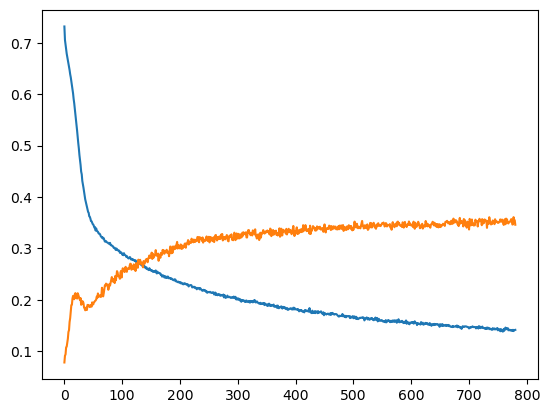

 65%|██████▌   | 782/1200 [01:42<00:52,  8.00it/s]

Epoch 781/1200 - loss: 0.14141473919153214, f1: 0.3460378039282068


 66%|██████▌   | 790/1200 [01:43<00:35, 11.71it/s]

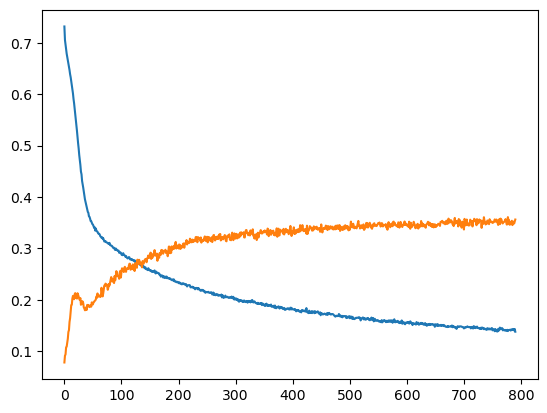

 66%|██████▌   | 792/1200 [01:43<00:39, 10.38it/s]

Epoch 791/1200 - loss: 0.13781799376010895, f1: 0.3561883858475695


 67%|██████▋   | 800/1200 [01:44<00:36, 11.00it/s]

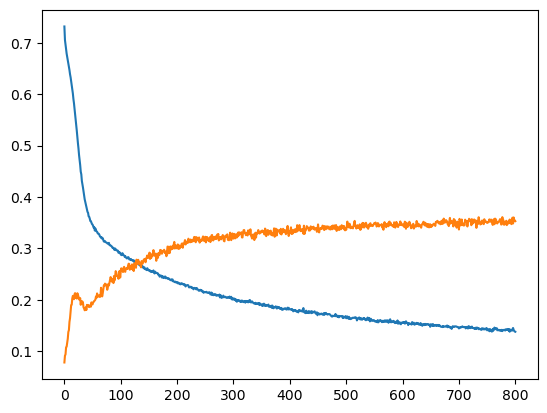

 67%|██████▋   | 804/1200 [01:44<00:33, 11.81it/s]

Epoch 801/1200 - loss: 0.1377914473414421, f1: 0.35296406819553466


 68%|██████▊   | 810/1200 [01:45<00:58,  6.68it/s]

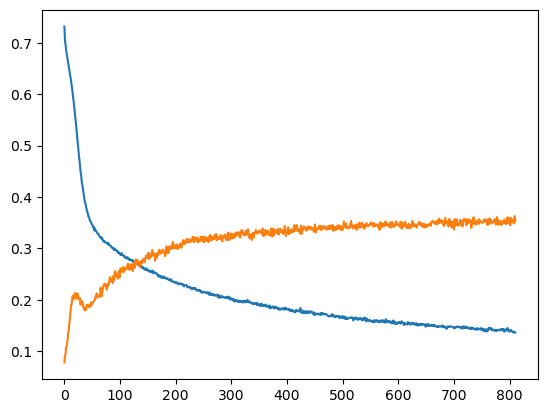

 68%|██████▊   | 813/1200 [01:46<00:47,  8.16it/s]

Epoch 811/1200 - loss: 0.13643549382686615, f1: 0.35423336885448764


 68%|██████▊   | 819/1200 [01:46<00:36, 10.43it/s]

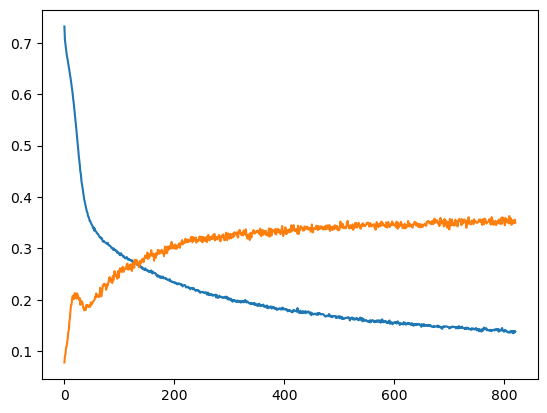

 69%|██████▊   | 823/1200 [01:46<00:33, 11.20it/s]

Epoch 821/1200 - loss: 0.13808025668064752, f1: 0.35010655104699095


 69%|██████▉   | 829/1200 [01:47<00:31, 11.64it/s]

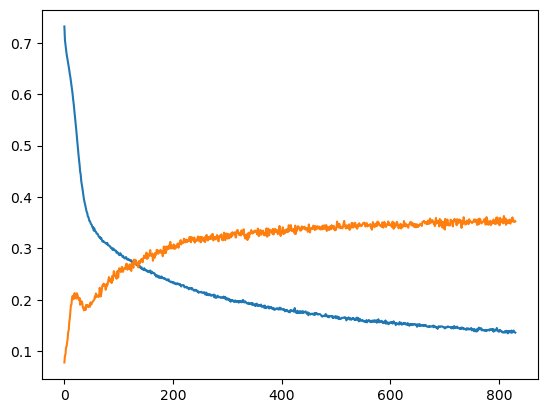

 69%|██████▉   | 833/1200 [01:47<00:31, 11.80it/s]

Epoch 831/1200 - loss: 0.135982113579909, f1: 0.35270139736709194


 70%|██████▉   | 839/1200 [01:48<00:27, 13.20it/s]

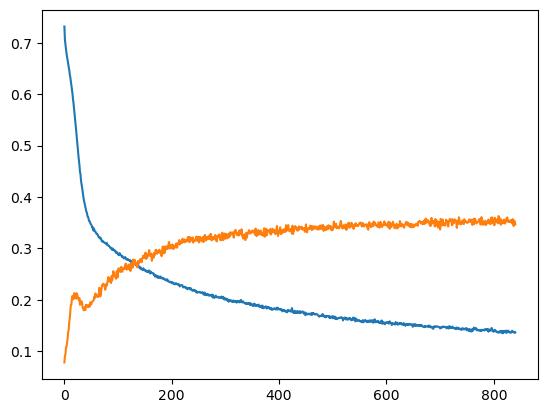

 70%|███████   | 843/1200 [01:48<00:28, 12.47it/s]

Epoch 841/1200 - loss: 0.13634210328261057, f1: 0.34667284154229827


 71%|███████   | 849/1200 [01:49<00:26, 13.19it/s]

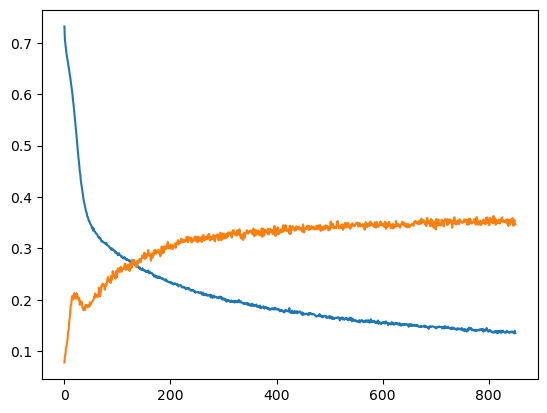

 71%|███████   | 853/1200 [01:49<00:26, 13.12it/s]

Epoch 851/1200 - loss: 0.13508279621601105, f1: 0.3467810798688745


 72%|███████▏  | 859/1200 [01:49<00:28, 11.89it/s]

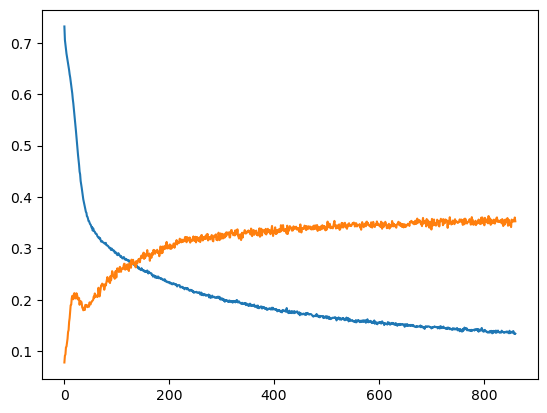

 72%|███████▏  | 863/1200 [01:50<00:28, 11.95it/s]

Epoch 861/1200 - loss: 0.13410249849160513, f1: 0.3527523699734804


 72%|███████▏  | 869/1200 [01:50<00:26, 12.67it/s]

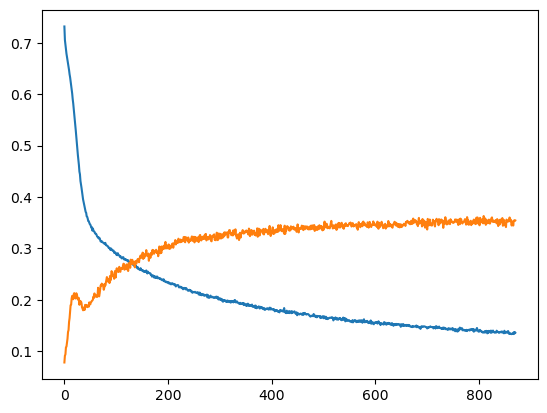

 73%|███████▎  | 873/1200 [01:51<00:25, 12.60it/s]

Epoch 871/1200 - loss: 0.13587422420581183, f1: 0.35444165075513456


 73%|███████▎  | 879/1200 [01:51<00:22, 14.30it/s]

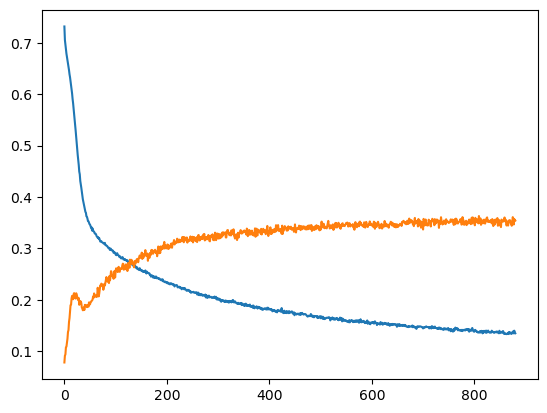

 74%|███████▎  | 883/1200 [01:51<00:25, 12.38it/s]

Epoch 881/1200 - loss: 0.13477965195973715, f1: 0.354116591015025


 74%|███████▍  | 889/1200 [01:52<00:26, 11.61it/s]

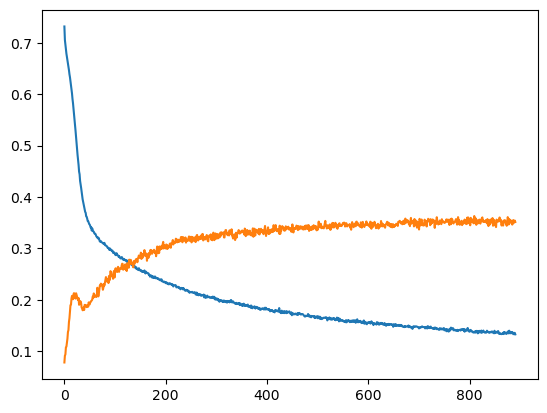

 74%|███████▍  | 893/1200 [01:52<00:26, 11.61it/s]

Epoch 891/1200 - loss: 0.1326464762290319, f1: 0.3514277360016571


 75%|███████▍  | 899/1200 [01:53<00:25, 11.91it/s]

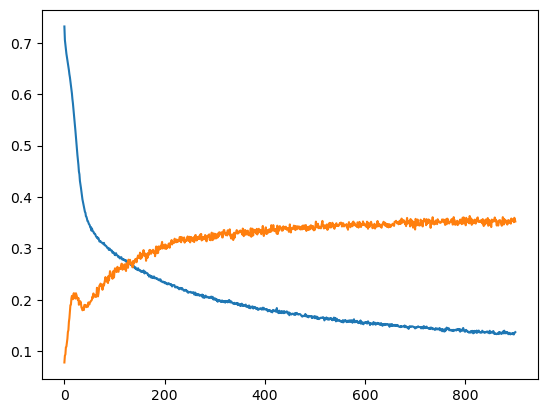

 75%|███████▌  | 903/1200 [01:53<00:24, 12.31it/s]

Epoch 901/1200 - loss: 0.13697022199630737, f1: 0.3524059658052635


 76%|███████▌  | 909/1200 [01:53<00:22, 12.74it/s]

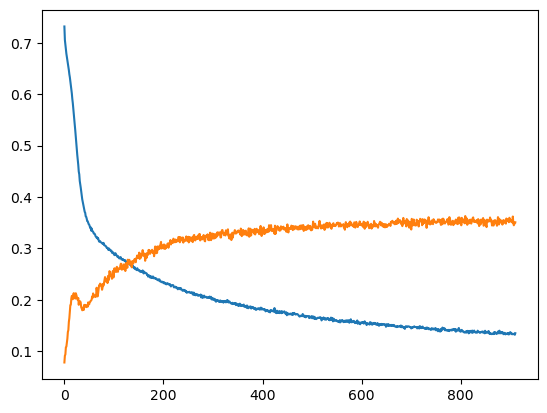

 76%|███████▌  | 913/1200 [01:54<00:22, 12.55it/s]

Epoch 911/1200 - loss: 0.1348967452843984, f1: 0.35081378065325886


 77%|███████▋  | 919/1200 [01:54<00:21, 13.34it/s]

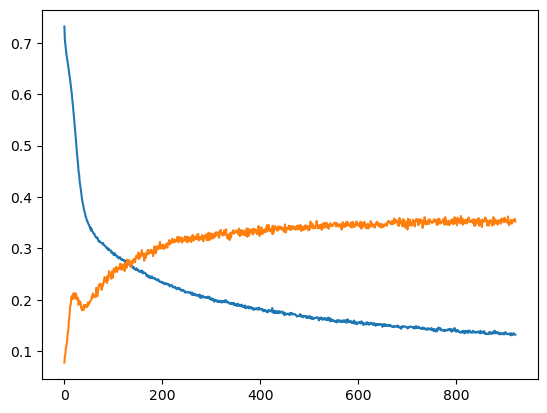

 77%|███████▋  | 921/1200 [01:54<00:27, 10.21it/s]

Epoch 921/1200 - loss: 0.13203691442807516, f1: 0.35235380525585974


 77%|███████▋  | 929/1200 [01:55<00:21, 12.33it/s]

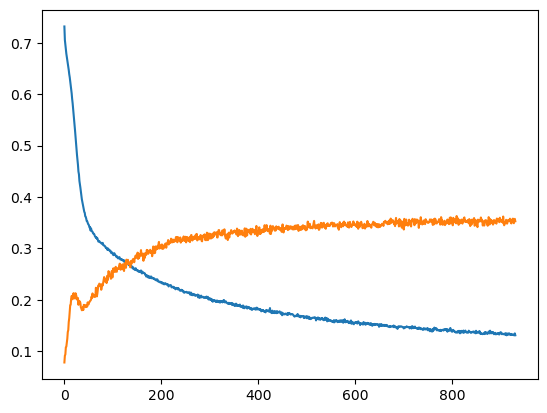

 78%|███████▊  | 933/1200 [01:55<00:21, 12.18it/s]

Epoch 931/1200 - loss: 0.1308625303208828, f1: 0.35283229678756983


 78%|███████▊  | 939/1200 [01:56<00:19, 13.14it/s]

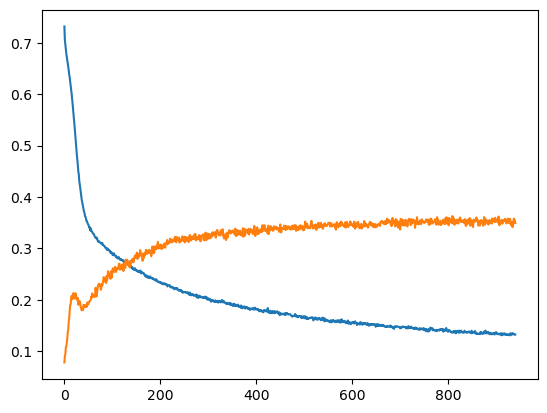

 79%|███████▊  | 943/1200 [01:56<00:20, 12.29it/s]

Epoch 941/1200 - loss: 0.13220346719026566, f1: 0.3492791504099243


 79%|███████▉  | 949/1200 [01:57<00:18, 13.61it/s]

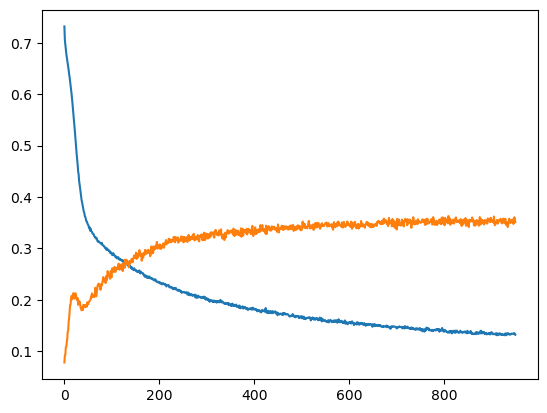

 79%|███████▉  | 951/1200 [01:57<00:20, 12.43it/s]

Epoch 951/1200 - loss: 0.1318709353605906, f1: 0.351179178999558


 80%|███████▉  | 959/1200 [01:58<00:18, 12.89it/s]

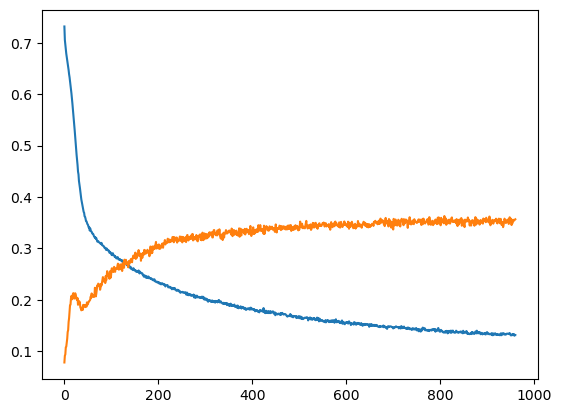

 80%|████████  | 963/1200 [01:58<00:19, 12.35it/s]

Epoch 961/1200 - loss: 0.13145780066649118, f1: 0.3566864355340814


 81%|████████  | 969/1200 [01:58<00:16, 13.85it/s]

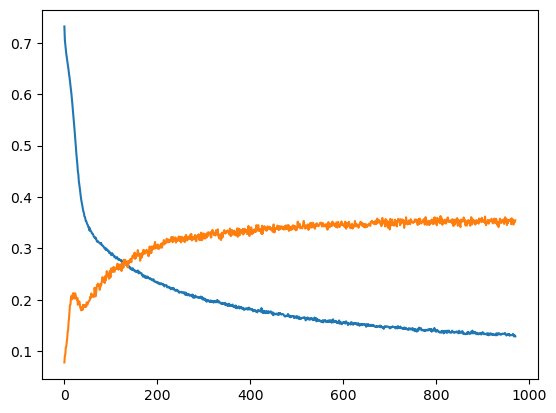

 81%|████████  | 973/1200 [01:59<00:18, 12.49it/s]

Epoch 971/1200 - loss: 0.1286653901139895, f1: 0.3547610287228794


 82%|████████▏ | 979/1200 [01:59<00:18, 12.07it/s]

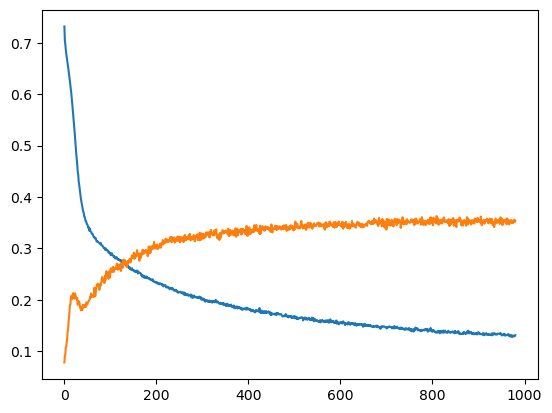

 82%|████████▏ | 983/1200 [01:59<00:17, 12.74it/s]

Epoch 981/1200 - loss: 0.1312370921174685, f1: 0.353281695467327


 82%|████████▏ | 989/1200 [02:00<00:17, 12.20it/s]

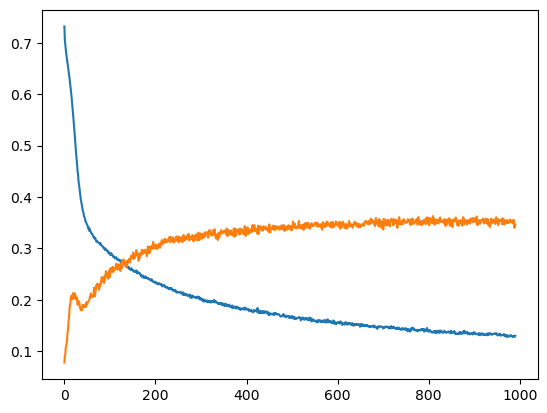

 83%|████████▎ | 993/1200 [02:00<00:16, 12.56it/s]

Epoch 991/1200 - loss: 0.12984531869490942, f1: 0.3462527780939251


 83%|████████▎ | 999/1200 [02:01<00:14, 13.84it/s]

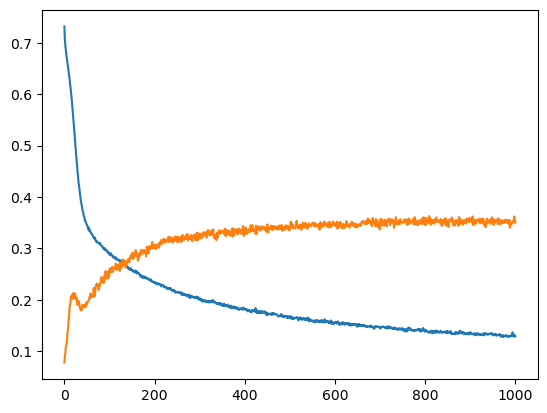

 84%|████████▎ | 1003/1200 [02:01<00:15, 12.61it/s]

Epoch 1001/1200 - loss: 0.128754124045372, f1: 0.3516719914246646


 84%|████████▍ | 1009/1200 [02:02<00:13, 13.80it/s]

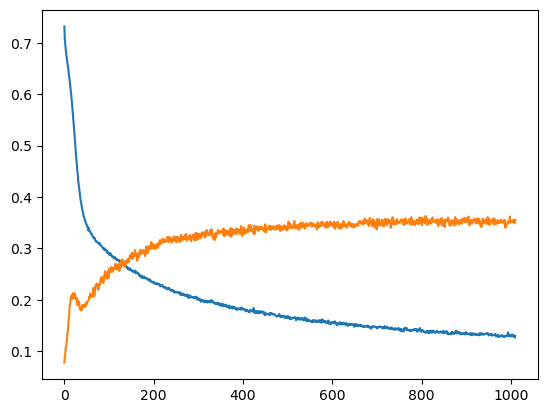

 84%|████████▍ | 1013/1200 [02:02<00:13, 13.50it/s]

Epoch 1011/1200 - loss: 0.12981807813048363, f1: 0.35356374508299526


 85%|████████▍ | 1019/1200 [02:02<00:16, 11.03it/s]

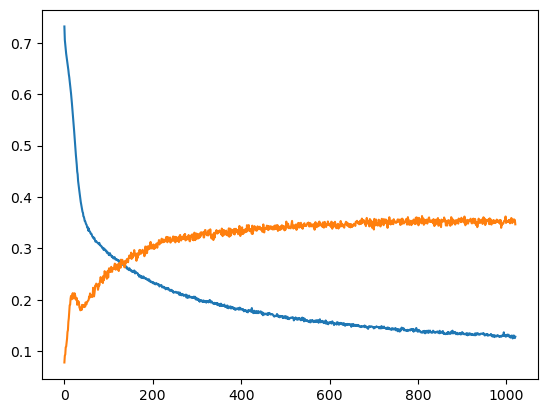

 85%|████████▌ | 1023/1200 [02:03<00:15, 11.69it/s]

Epoch 1021/1200 - loss: 0.12814472615718842, f1: 0.34687722238060026


 86%|████████▌ | 1029/1200 [02:03<00:12, 13.30it/s]

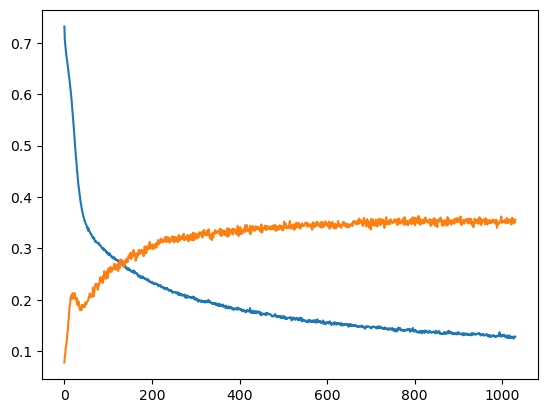

 86%|████████▌ | 1033/1200 [02:04<00:13, 12.43it/s]

Epoch 1031/1200 - loss: 0.1283881018559138, f1: 0.35569268899934603


 87%|████████▋ | 1039/1200 [02:04<00:11, 13.72it/s]

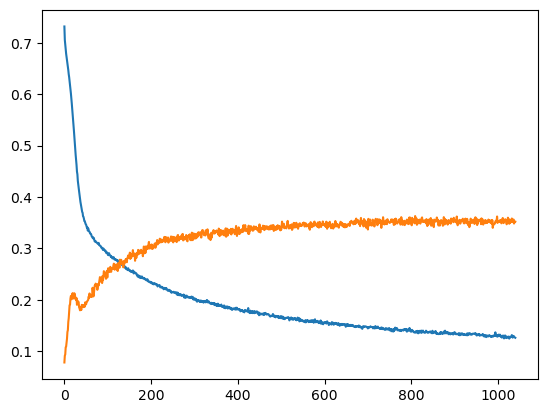

 87%|████████▋ | 1043/1200 [02:04<00:13, 11.52it/s]

Epoch 1041/1200 - loss: 0.1260445478061835, f1: 0.352100697215922


 87%|████████▋ | 1049/1200 [02:05<00:11, 12.82it/s]

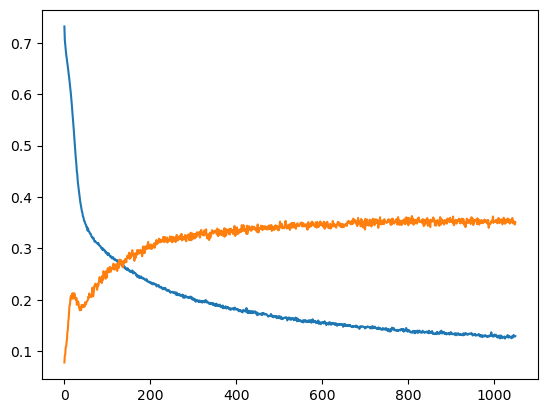

 88%|████████▊ | 1053/1200 [02:05<00:13, 10.92it/s]

Epoch 1051/1200 - loss: 0.1292192985614141, f1: 0.351065334552664


 88%|████████▊ | 1059/1200 [02:06<00:10, 12.97it/s]

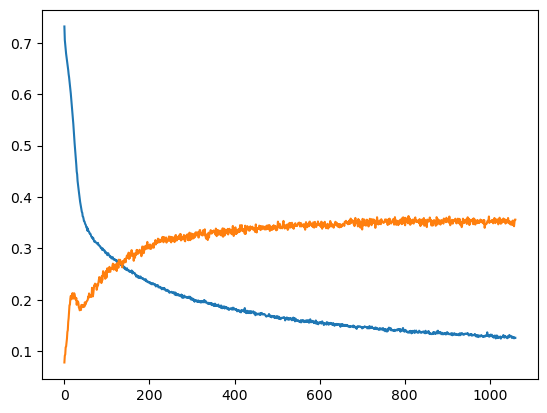

 89%|████████▊ | 1063/1200 [02:06<00:11, 12.41it/s]

Epoch 1061/1200 - loss: 0.1258853611846765, f1: 0.3559852184521498


 89%|████████▉ | 1069/1200 [02:06<00:10, 12.24it/s]

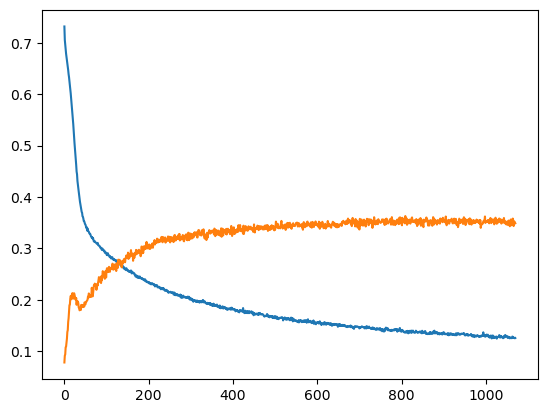

 89%|████████▉ | 1073/1200 [02:07<00:10, 12.37it/s]

Epoch 1071/1200 - loss: 0.1255219466984272, f1: 0.34884151218226667


 90%|████████▉ | 1079/1200 [02:07<00:09, 12.46it/s]

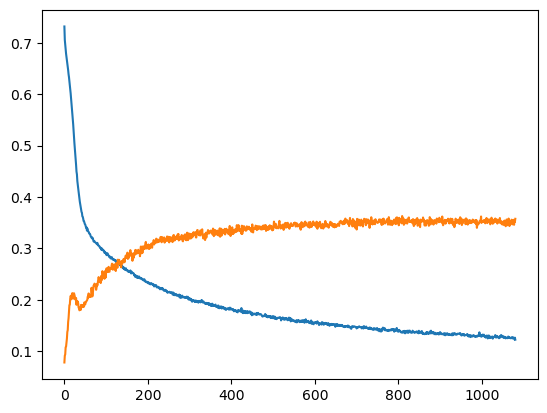

 90%|█████████ | 1081/1200 [02:07<00:10, 11.63it/s]

Epoch 1081/1200 - loss: 0.12239196275671323, f1: 0.3575929787081675


 91%|█████████ | 1089/1200 [02:08<00:09, 12.19it/s]

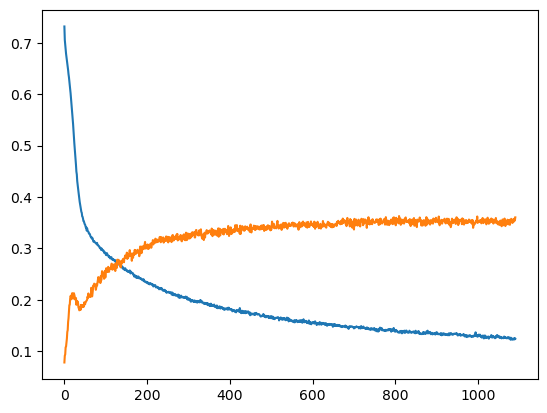

 91%|█████████ | 1093/1200 [02:09<00:09, 11.75it/s]

Epoch 1091/1200 - loss: 0.12419531246026357, f1: 0.3603954252853919


 92%|█████████▏| 1099/1200 [02:09<00:07, 13.34it/s]

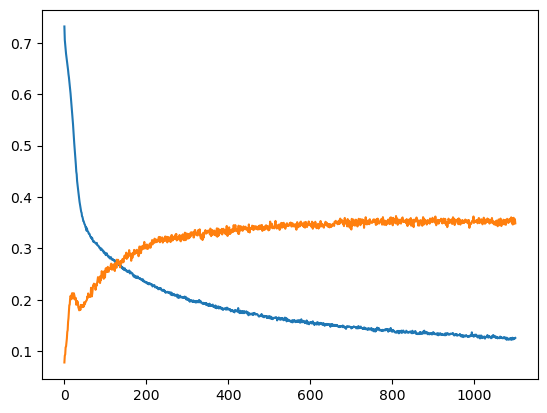

 92%|█████████▏| 1103/1200 [02:09<00:07, 12.55it/s]

Epoch 1101/1200 - loss: 0.12567036474744478, f1: 0.34888741118942523


 92%|█████████▏| 1109/1200 [02:10<00:06, 13.34it/s]

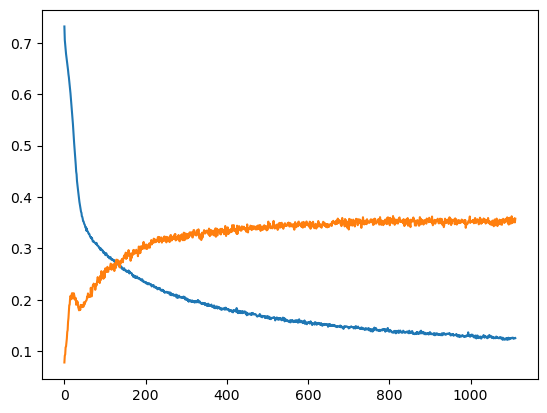

 93%|█████████▎| 1113/1200 [02:10<00:06, 13.01it/s]

Epoch 1111/1200 - loss: 0.1253871334095796, f1: 0.3577146914598065


 93%|█████████▎| 1119/1200 [02:11<00:07, 11.48it/s]

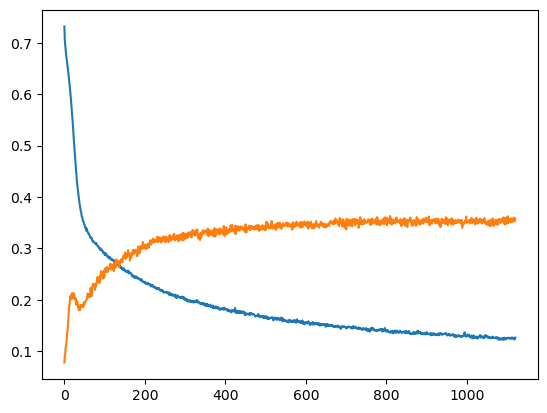

 94%|█████████▎| 1123/1200 [02:11<00:06, 11.21it/s]

Epoch 1121/1200 - loss: 0.12630399937431017, f1: 0.35778502892120867


 94%|█████████▍| 1129/1200 [02:11<00:05, 13.17it/s]

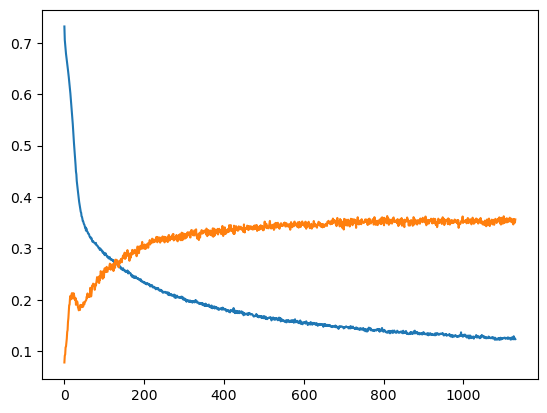

 94%|█████████▍| 1131/1200 [02:12<00:05, 12.04it/s]

Epoch 1131/1200 - loss: 0.12329981103539467, f1: 0.3563884133040958


 95%|█████████▍| 1139/1200 [02:13<00:06,  9.86it/s]

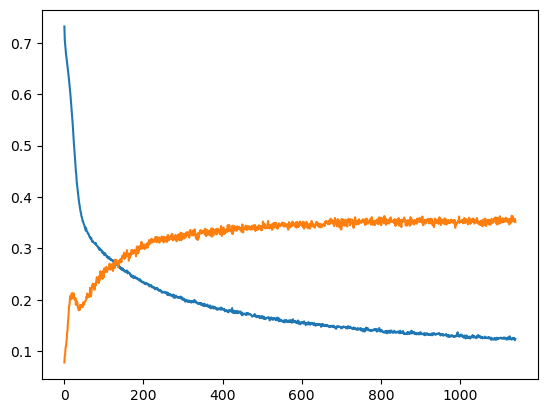

 95%|█████████▌| 1143/1200 [02:13<00:05, 10.84it/s]

Epoch 1141/1200 - loss: 0.12386101235946019, f1: 0.3511326336983356


 96%|█████████▌| 1149/1200 [02:14<00:08,  6.35it/s]

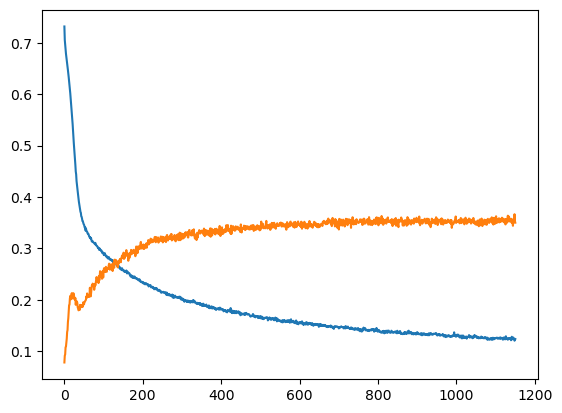

 96%|█████████▌| 1153/1200 [02:14<00:05,  8.28it/s]

Epoch 1151/1200 - loss: 0.1235373926659425, f1: 0.3500389331897842


 97%|█████████▋| 1159/1200 [02:15<00:03, 10.44it/s]

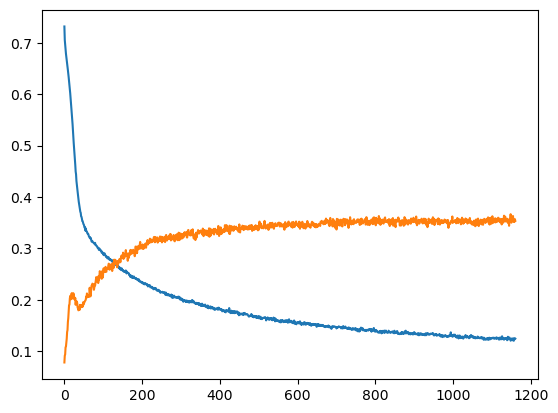

 97%|█████████▋| 1163/1200 [02:15<00:03, 10.94it/s]

Epoch 1161/1200 - loss: 0.12433962772289912, f1: 0.353652661785247


 97%|█████████▋| 1169/1200 [02:16<00:02, 12.73it/s]

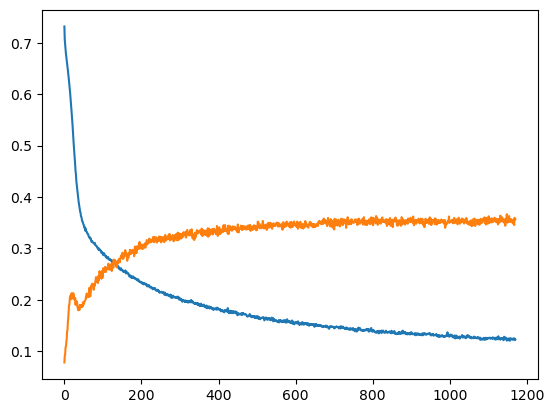

 98%|█████████▊| 1173/1200 [02:16<00:02, 12.27it/s]

Epoch 1171/1200 - loss: 0.12221158295869827, f1: 0.35683788894966695


 98%|█████████▊| 1179/1200 [02:17<00:01, 11.59it/s]

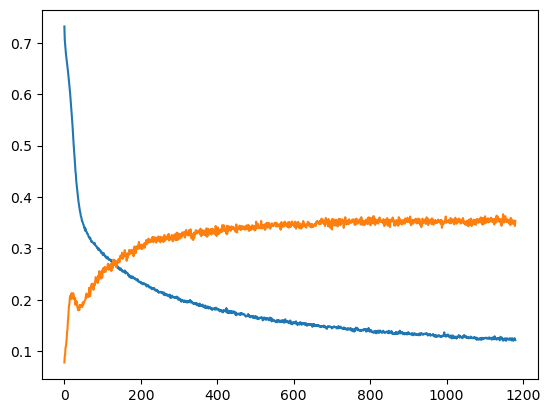

 99%|█████████▊| 1183/1200 [02:17<00:01, 12.19it/s]

Epoch 1181/1200 - loss: 0.1216778780023257, f1: 0.3537073617236876


 99%|█████████▉| 1189/1200 [02:17<00:00, 12.15it/s]

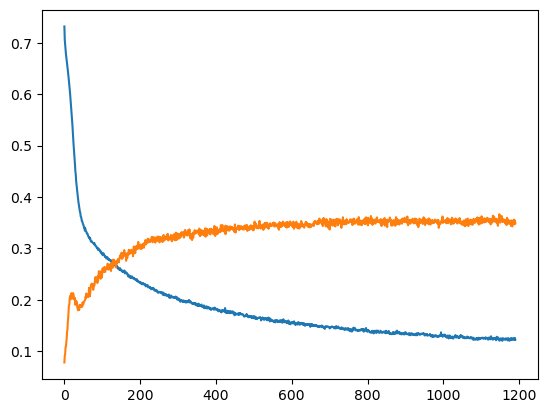

 99%|█████████▉| 1193/1200 [02:18<00:00, 12.48it/s]

Epoch 1191/1200 - loss: 0.12246844172477722, f1: 0.34912999623359325


100%|██████████| 1200/1200 [02:18<00:00,  8.64it/s]


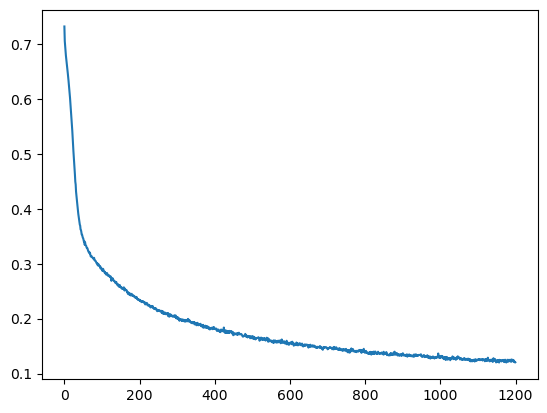

In [10]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1200
losses = []
metrics = []

best_metric = 0

for epoch in tqdm(range(epochs)):

    total_loss = 0
    total_metric = 0
    
    # 
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        outputs = torch.where(outputs > 0.75, 1, 0)
        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        total_metric += f1_score(labels, outputs, average="weighted")

    losses.append(total_loss / len(data_loader))
    metrics.append(total_metric / len(val_loader))
    
    if epoch % 10 == 0:
        plt.plot(losses)
        plt.plot(metrics)
        plt.show()
        print(f"Epoch {epoch + 1}/{epochs} - loss: {losses[-1]}, f1: {metrics[-1]}")

    if metrics[-1] > best_metric:
        best_metric = metrics[-1]
        torch.save(model.state_dict(), "models/hv_classifier.pt")
        
losses = np.array(losses)
np.save("models/hv_classifier_losses.npy", losses)
plt.plot(losses)

In [11]:

outputs = model.predict(df_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(df_labels, outputs, target_names=df.columns[:-1]))

                            precision    recall  f1-score   support

                    Merged       0.95      0.68      0.79       988
   Self-direction: thought       0.98      0.83      0.90      1395
    Self-direction: action       0.65      0.04      0.08       247
               Stimulation       0.80      0.09      0.17       172
                  Hedonism       0.98      0.82      0.89      1512
               Achievement       0.93      0.26      0.40       610
          Power: dominance       0.97      0.76      0.85       625
          Power: resources       0.00      0.00      0.00       382
                      Face       0.98      0.83      0.90      2000
        Security: personal       0.98      0.89      0.93      1728
        Security: societal       0.91      0.58      0.71       568
                 Tradition       0.97      0.78      0.86      1177
         Conformity: rules       0.87      0.10      0.17       207
 Conformity: interpersonal       0.91      0.23

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
validation_inputs, validation_labels = load_data("datasets/validation_merged.csv")

outputs = model.predict(validation_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(validation_labels, outputs, target_names=df.columns[:-1]))

# save classification report as CSV
report = classification_report(validation_labels, outputs, target_names=df.columns[:-1], output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv("reports/validation_performance.csv")


c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\m

                            precision    recall  f1-score   support

                    Merged       0.40      0.27      0.32       251
   Self-direction: thought       0.46      0.34      0.39       496
    Self-direction: action       0.38      0.02      0.04       138
               Stimulation       0.43      0.03      0.05       103
                  Hedonism       0.59      0.42      0.49       575
               Achievement       0.24      0.05      0.08       164
          Power: dominance       0.30      0.22      0.25       132
          Power: resources       0.00      0.00      0.00       130
                      Face       0.62      0.46      0.53       759
        Security: personal       0.39      0.39      0.39       488
        Security: societal       0.40      0.23      0.30       172
                 Tradition       0.48      0.32      0.39       455
         Conformity: rules       0.00      0.00      0.00        60
 Conformity: interpersonal       0.10      0.02

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│    8 # save classification report as CSV                                                         │
│    9 report = classification_report(validation_labels, outputs, target_names=df.columns[:-1],    │
│   10 report = pd.DataFrame(report).transpose()                                                   │
│ ❱ 11 report.to_csv("reports/hv_classifier.csv")                                                  │
│   12                                                                                             │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\pandas\util\_decorators.py:211 in wrapper    │
│                                                                                                  │
│   208 │   │   │   │   │   raise TypeError(msg)                                                   │
│   209 │   │   │   │   else:                                                                      │
│   210 │   │   │   │   │   kwargs[new_arg_name] = new_arg_value                                   │
│ ❱ 211 │   │   │   return func(*args, **kwargs)                                                   │
│   212 │   │                                                                                      │
│   213 │   │   return cast(F, wrapper)                                                            │
│   214                                                                                            │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\pandas\core\generic.py:3720 in to_csv        │
│                                                                                                  │
│    3717 │   │   │   decimal=decimal,                                                             │
│    3718 │   │   )                                                                                │
│    3719 │   │                                                                                    │
│ ❱  3720 │   │   return DataFrameRenderer(formatter).to_csv(                                      │
│    3721 │   │   │   path_or_buf,                                                                 │
│    3722 │   │   │   lineterminator=lineterminator,                                               │
│    3723 │   │   │   sep=sep,                                                                     │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\pandas\util\_decorators.py:211 in wrapper    │
│                                                                                                  │
│   208 │   │   │   │   │   raise TypeError(msg)                                                   │
│   209 │   │   │   │   else:                                                                      │
│   210 │   │   │   │   │   kwargs[new_arg_name] = new_arg_value                                   │
│ ❱ 211 │   │   │   return func(*args, **kwargs)                                                   │
│   212 │   │                                                                                      │
│   213 │   │   return cast(F, wrapper)                                                            │
│   214                                                                                            │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\pandas\